# Predicting Football Player Positions Using Performance Statistics from Top 5 European Leagues (2023–2024)

## Overview
This notebook demonstrates how to build a machine learning model to predict football player positions based on their performance statistics. The dataset contains player statistics from the top 5 European leagues for the 2023–2024 season.

## Table of Contents
1. [Data Loading and Exploration](#1-data-loading-and-exploration)
2. [Data Preprocessing](#2-data-preprocessing)
3. [Exploratory Data Analysis](#3-exploratory-data-analysis)
4. [Feature Engineering and Model Preparation](#4-feature-engineering-and-model-preparation)
5. [Model Training and Cross-Validation](#5-model-training-and-cross-validation)
6. [Model Evaluation](#6-model-evaluation)
7. [Classification Report Visualization](#7-classification-report-visualization)
8. [ROC-AUC Curves](#8-roc-auc-curves)
9. [Feature Importance Analysis](#9-feature-importance-analysis)
10. [Model Serialization](#10-model-serialization)
11. [Model Performance Summary](#11-model-performance-summary)
12. [Conclusion](#12-conclusion-and-key-findings)

## Libraries and Setup


In [1]:
# Import all necessary libraries

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# File operations and serialization
import pathlib
import joblib
from typing import Dict, Tuple, Optional, Any

# Machine learning imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                           roc_curve, auc, roc_auc_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Set plot style for better visualization
sns.set_style("whitegrid")

# Create an artifacts directory for saving model outputs and visualizations
pathlib.Path("artifacts").mkdir(exist_ok=True)

## 1. Data Loading and Exploration
Load the dataset and explore its basic properties.

### Purpose of This Section:
- **Data Understanding**: Get familiar with the structure and content of our dataset
- **Initial Assessment**: Check data types, missing values, and basic statistics
- **Target Distribution**: Examine the distribution of player positions (our target variable)
- **Data Quality**: Identify potential issues that might need addressing in preprocessing

### What We're Looking For:
- **Dataset Size**: Number of players and features available for analysis
- **Feature Types**: Numerical statistics vs. categorical information
- **Position Distribution**: How many players in each position category
- **Potential Challenges**: Class imbalance, missing data, or unusual values

This initial exploration helps us understand what we're working with and informs our preprocessing decisions.


In [2]:
# Define function to load data
def load_data(file_path: str) -> pd.DataFrame:
    if not pathlib.Path(file_path).exists():
        raise FileNotFoundError(f"Data file not found at {file_path}")

    print(f"Loading data from {file_path}...")
    loaded_df = pd.read_csv(file_path)
    print(f"Dataset shape: {loaded_df.shape} (rows, columns)")
    return loaded_df

# Load the data using the load_data function
df = load_data('data/top5-players.csv')

# Define function to explore data
def explore_data(data_frame: pd.DataFrame) -> Dict[str, Any]:
    # Extract the primary position (first position listed)
    data_frame['Primary_Position'] = data_frame['Pos'].str.split(',').str[0].str.strip()

    # Collect exploration results
    exploration_data = {
        'shape': data_frame.shape,
        'columns': data_frame.columns.tolist(),
        'sample_data': data_frame.head(),
        'position_counts': data_frame['Pos'].value_counts(),
        'primary_position_counts': data_frame['Primary_Position'].value_counts(),
        'unique_primary_positions': data_frame['Primary_Position'].nunique()
    }

    return exploration_data

# Explore the data
exploration_results = explore_data(df)


Loading data from data/top5-players.csv...
Dataset shape: (2852, 37) (rows, columns)


In [3]:
# Display column names
print("\nColumn names:")
print(exploration_results['columns'])



Column names:
['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'Gls_90', 'Ast_90', 'G+A_90', 'G-PK_90', 'G+A-PK_90', 'xG_90', 'xAG_90', 'xG+xAG_90', 'npxG_90', 'npxG+xAG_90', 'Primary_Position']


In [4]:
# Display the first five rows
print("\nFirst five rows:")
print(exploration_results['sample_data'])



First five rows:
   Rk             Player   Nation    Pos           Squad                Comp  \
0   1         Max Aarons  eng ENG     DF     Bournemouth  eng Premier League   
1   2   Brenden Aaronson   us USA  MF,FW    Union Berlin       de Bundesliga   
2   3    Paxten Aaronson   us USA     MF  Eint Frankfurt       de Bundesliga   
3   4  Keyliane Abdallah   fr FRA     FW       Marseille          fr Ligue 1   
4   5   Yunis Abdelhamid   ma MAR     DF           Reims          fr Ligue 1   

    Age    Born  MP  Starts  ...  Ast_90  G+A_90  G-PK_90  G+A-PK_90  xG_90  \
0  23.0  2000.0  20      13  ...    0.07    0.07     0.00       0.07   0.00   
1  22.0  2000.0  30      14  ...    0.14    0.28     0.14       0.28   0.14   
2  19.0  2003.0   7       1  ...    0.89    0.89     0.00       0.89   0.11   
3  17.0  2006.0   1       0  ...    0.00    0.00     0.00       0.00   0.00   
4  35.0  1987.0  31      31  ...    0.00    0.13     0.10       0.10   0.11   

   xAG_90  xG+xAG_90  npxG

In [5]:
# Show the distribution of primary positions
print("\nDistribution of primary positions:")
print(exploration_results['primary_position_counts'])
print(f"Number of unique primary positions: {exploration_results['unique_primary_positions']}")



Distribution of primary positions:
Primary_Position
DF    1003
MF     895
FW     751
GK     203
Name: count, dtype: int64
Number of unique primary positions: 4


## 2. Data Preprocessing
Clean and prepare the data for modeling.

### Key Preprocessing Steps:
1. **Handling Missing Values**: Removing rows with missing position data and imputing other missing values
2. **Feature Extraction**: Creating a 'Primary_Position' feature from the 'Pos' column
3. **Removing Identifiers**: Dropping columns that don't contribute to prediction (e.g., player names)
4. **Data Cleaning**: Ensuring data consistency and quality

### Why Preprocessing is Critical:
- **Data Quality**: Machine learning models require clean, consistent data
- **Feature Relevance**: Not all available data is useful for prediction
- **Missing Data Strategy**: How we handle missing values affects model performance
- **Target Definition**: Clearly defining what we're trying to predict (primary position)

The preprocessing steps ensure our data is in the optimal format for machine learning algorithms and help prevent common issues like data leakage or biased predictions.


In [6]:
# Define function to preprocess data
def preprocess_data(data_frame: pd.DataFrame) -> pd.DataFrame:
    # Create a copy to avoid modifying the original data
    processed_df = data_frame.copy()

    # 1. Remove rows where 'Pos' is NaN
    print(f"Number of rows before removing NaN Pos: {processed_df.shape[0]}")
    processed_df = processed_df[processed_df['Pos'].notna()]
    print(f"Number of rows after removing NaN Pos: {processed_df.shape[0]}")

    # 2. Extract primary position
    processed_df['Primary_Position'] = processed_df['Pos'].str.split(',').str[0].str.strip()

    # 3. Drop identifier columns
    identifier_columns = ['Rk', 'Player', 'Born']
    processed_df = processed_df.drop(columns=identifier_columns)

    # 4. Handle missing values
    # Identify numerical and categorical columns
    numerical_cols = processed_df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = processed_df.select_dtypes(include=['object']).columns

    # Impute numeric NaNs with median
    for col in numerical_cols:
        if processed_df[col].isnull().sum() > 0:
            median_value = processed_df[col].median()
            processed_df[col] = processed_df[col].fillna(median_value)

    # Impute categorical NaNs with "Unknown"
    for col in categorical_cols:
        if processed_df[col].isnull().sum() > 0:
            processed_df[col] = processed_df[col].fillna("Unknown")

    # Verify no missing values remain
    missing_values = processed_df.isnull().sum().sum()
    print(f"{missing_values} missing values remaining")

    return processed_df

# Preprocess the data using the preprocess_data function
df_clean = preprocess_data(df)

# Show class distribution after cleaning to check for class imbalance
print("\nClass distribution after cleaning:")
print(df_clean['Primary_Position'].value_counts())
print(f"Number of unique primary positions: {df_clean['Primary_Position'].nunique()}")


Number of rows before removing NaN Pos: 2852
Number of rows after removing NaN Pos: 2852
0 missing values remaining

Class distribution after cleaning:
Primary_Position
DF    1003
MF     895
FW     751
GK     203
Name: count, dtype: int64
Number of unique primary positions: 4


## 3. Exploratory Data Analysis
Visualize the data to gain insights.

### Purpose of Data Visualization:
- **Pattern Discovery**: Identify patterns and relationships in the data that might not be obvious from raw numbers
- **Feature Understanding**: Gain a deeper understanding of individual features and their distributions
- **Relationship Exploration**: Discover correlations and dependencies between different player statistics
- **Hypothesis Generation**: Form initial hypotheses about which features might be most predictive

### Visualizations in This Section:
1. **Position Distribution**: Bar chart showing the count of players in each position
2. **Age Distribution by Position**: Box plots showing age patterns across positions
3. **Minutes Played by Position**: Box plots showing playing time patterns
4. **Correlation Heatmap**: Matrix showing correlations between numerical features

These visualizations help us understand the data better before building our machine learning models and can inform feature engineering and model selection decisions.


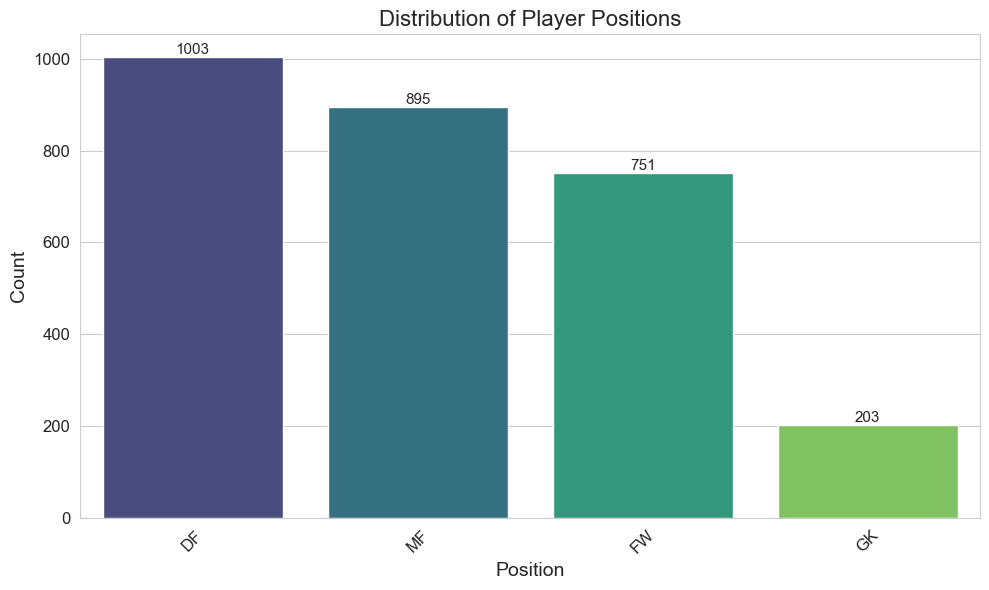

In [7]:
# Define function to plot position distribution
def plot_position_distribution(data_frame: pd.DataFrame, save_path: Optional[str] = None):
    plt.figure(figsize=(10, 6))
    position_ax = sns.countplot(x='Primary_Position', hue='Primary_Position', 
                       data=data_frame, palette='viridis', legend=False)
    plt.title('Distribution of Player Positions', fontsize=16)
    plt.xlabel('Position', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)

    # Add count labels on top of each bar
    for p in position_ax.patches:
        position_ax.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='bottom', fontsize=11)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Position distribution plot saved to {save_path}")

    plt.show()

# 1. Distribution of Player Positions
# This visualization shows the frequency of each player position in the dataset
# Purpose: To understand the class distribution and identify potential class imbalance issues
plot_position_distribution(df_clean)


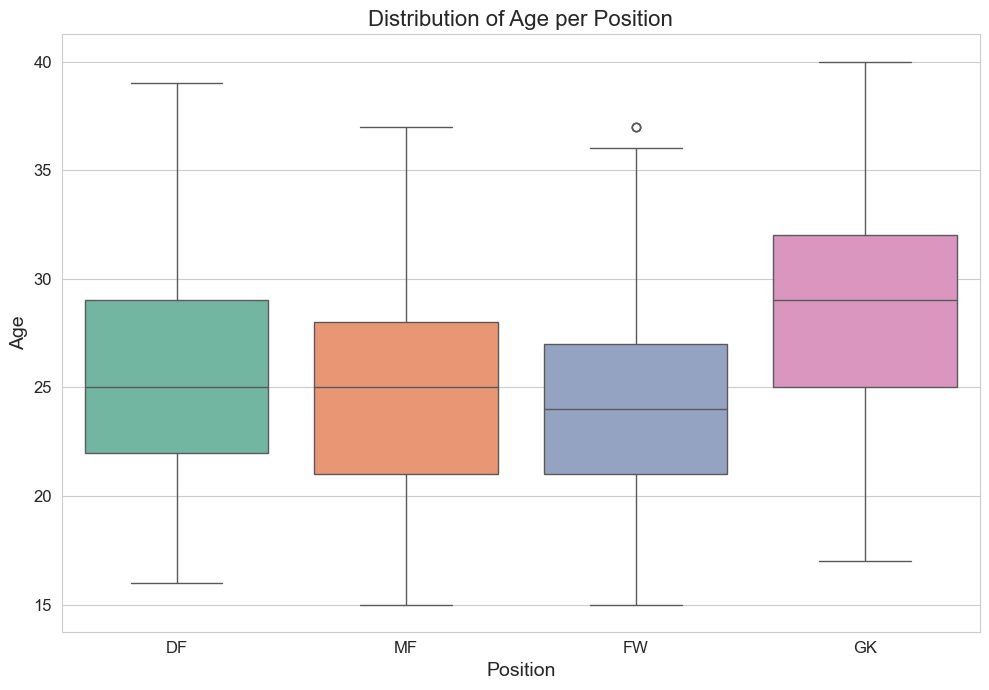

In [8]:
# Define function to plot age distribution by position
def plot_age_distribution_by_position(data_frame: pd.DataFrame, save_path: Optional[str] = None):
    plt.figure(figsize=(10, 7))

    # Plot: Age Distribution by Position
    sns.boxplot(x='Primary_Position', y='Age', hue='Primary_Position', data=data_frame, palette='Set2', legend=False)
    plt.title('Distribution of Age per Position', fontsize=16)
    plt.xlabel('Position', fontsize=14)
    plt.ylabel('Age', fontsize=14)
    plt.tick_params(axis='x', rotation=0, labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Age distribution by position plot saved to {save_path}")

    plt.show()

# 2. Age Distribution by Position
# This visualization shows age patterns across positions
# Purpose: To understand age distribution across different positions
plot_age_distribution_by_position(df_clean)


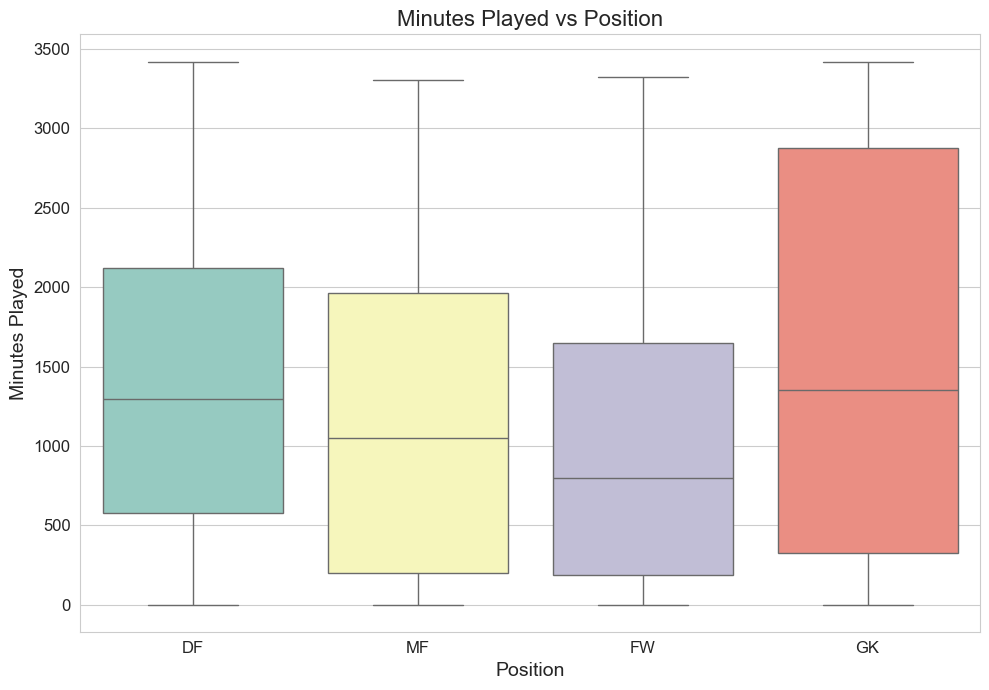

In [9]:
# Define function to plot minutes played by position
def plot_minutes_played_by_position(data_frame: pd.DataFrame, save_path: Optional[str] = None):
    plt.figure(figsize=(10, 7))

    # Plot: Minutes Played by Position
    sns.boxplot(x='Primary_Position', y='Min', hue='Primary_Position', data=data_frame, palette='Set3', legend=False)
    plt.title('Minutes Played vs Position', fontsize=16)
    plt.xlabel('Position', fontsize=14)
    plt.ylabel('Minutes Played', fontsize=14)
    plt.tick_params(axis='x', rotation=0, labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Minutes played by position plot saved to {save_path}")

    plt.show()

# 3. Minutes Played by Position
# This visualization shows playing time patterns across positions
# Purpose: To understand which positions get more playing time
plot_minutes_played_by_position(df_clean)


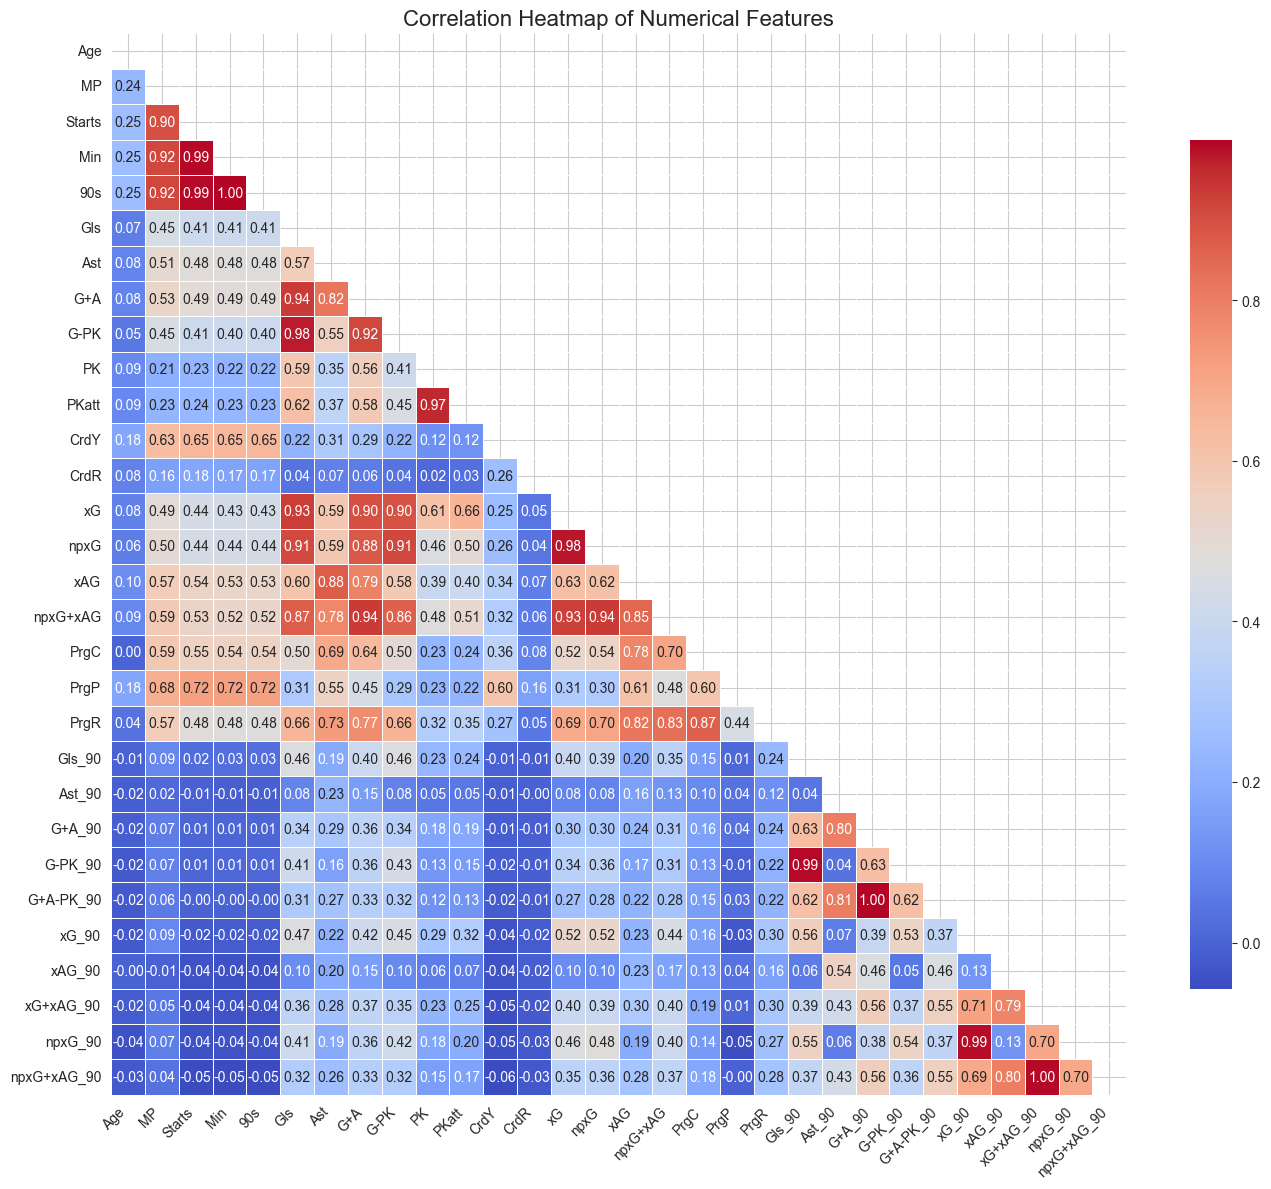

In [10]:
# Define function to plot correlation heatmap
def plot_correlation_heatmap(data_frame: pd.DataFrame, save_path: Optional[str] = None):
    plt.figure(figsize=(14, 12))

    # Select only numerical columns for correlation
    numerical_features = data_frame.select_dtypes(include=['int64', 'float64'])

    # Calculate correlation matrix
    corr_matrix = numerical_features.corr()

    # Create heatmap with upper triangle masked
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
                cmap='coolwarm', linewidths=0.5, cbar_kws={"shrink": .8})

    plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Correlation heatmap saved to {save_path}")

    plt.show()

# 4. Heatmap of Numerical Feature Correlations
# This visualization shows the correlation between all numerical features in the dataset
# Purpose: To identify relationships between features and potential multicollinearity issues
# Strong correlations (close to 1 or -1) indicate features that may contain redundant information
plot_correlation_heatmap(df_clean)


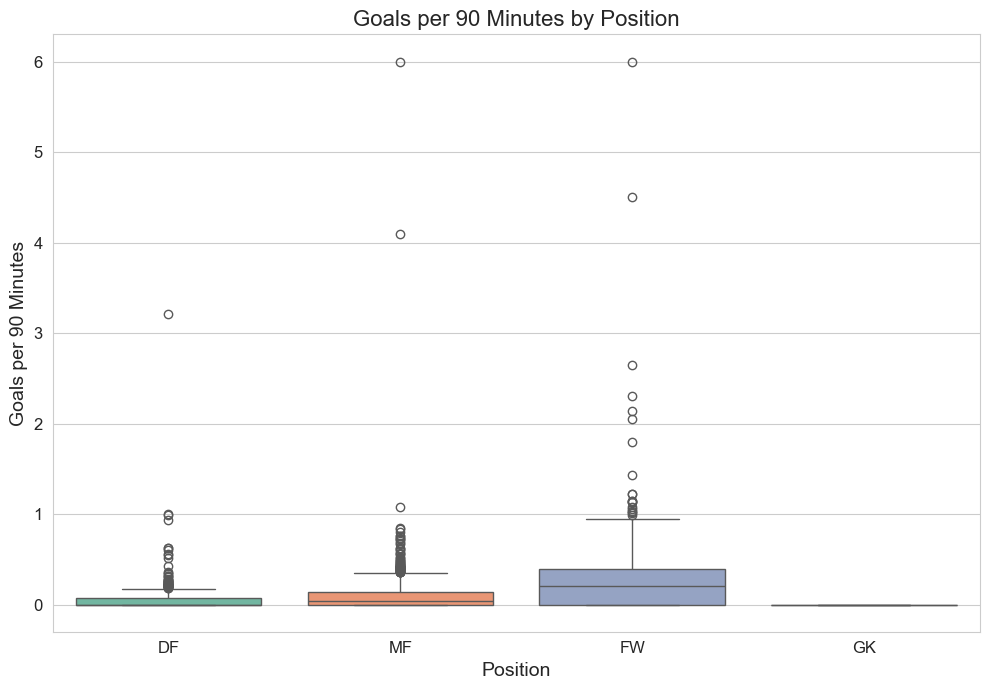

In [11]:
# Define function to plot goals per 90 minutes by position
def plot_goals_per_90_by_position(data_frame: pd.DataFrame, save_path: Optional[str] = None):
    plt.figure(figsize=(10, 7))

    # Plot: Goals per 90 Minutes by Position
    sns.boxplot(x='Primary_Position', y='Gls_90', hue='Primary_Position', data=data_frame, palette='Set2', legend=False)
    plt.title('Goals per 90 Minutes by Position', fontsize=16)
    plt.xlabel('Position', fontsize=14)
    plt.ylabel('Goals per 90 Minutes', fontsize=14)
    plt.tick_params(axis='x', rotation=0, labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Goals per 90 minutes plot saved to {save_path}")

    plt.show()

# 5. Goals per 90 Minutes by Position
# This visualization shows goal-scoring patterns across positions
# Purpose: To understand which positions score more goals per 90 minutes
plot_goals_per_90_by_position(df_clean)


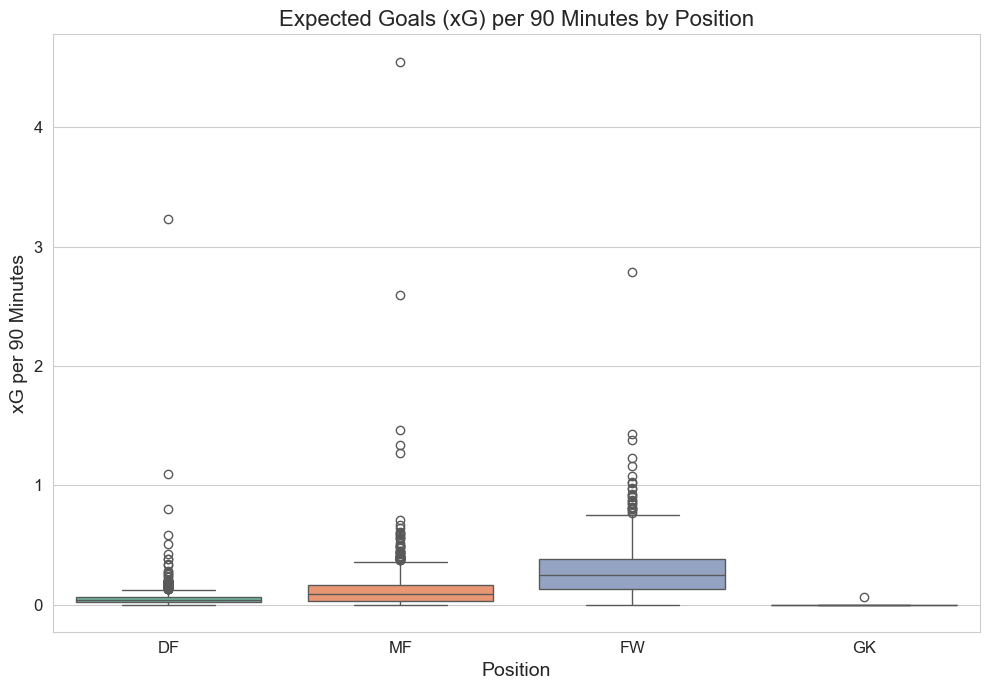

In [12]:
# Define function to plot expected goals per 90 minutes by position
def plot_expected_goals_per_90_by_position(data_frame: pd.DataFrame, save_path: Optional[str] = None):
    plt.figure(figsize=(10, 7))

    # Plot: Expected Goals (xG) per 90 Minutes by Position
    sns.boxplot(x='Primary_Position', y='xG_90', hue='Primary_Position', data=data_frame, palette='Set2', legend=False)
    plt.title('Expected Goals (xG) per 90 Minutes by Position', fontsize=16)
    plt.xlabel('Position', fontsize=14)
    plt.ylabel('xG per 90 Minutes', fontsize=14)
    plt.tick_params(axis='x', rotation=0, labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Expected goals per 90 minutes plot saved to {save_path}")

    plt.show()

# 6. Expected Goals (xG) per 90 Minutes by Position
# This visualization shows expected goal patterns across positions
# Purpose: To understand which positions have higher expected goals per 90 minutes
plot_expected_goals_per_90_by_position(df_clean)


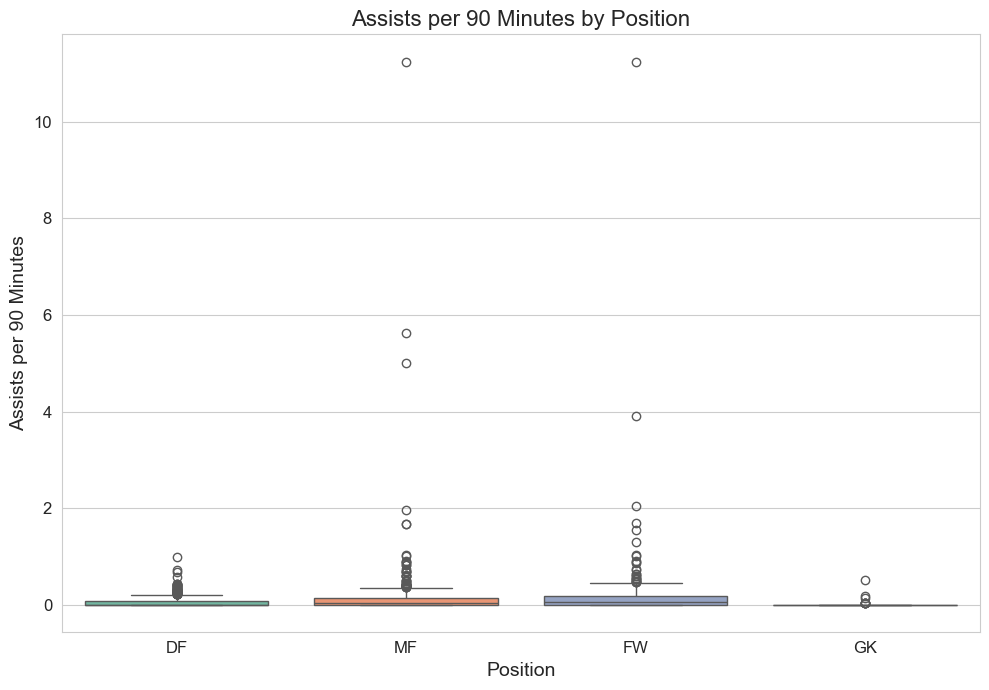

In [13]:
# Define function to plot assists per 90 minutes by position
def plot_assists_per_90_by_position(data_frame: pd.DataFrame, save_path: Optional[str] = None):
    plt.figure(figsize=(10, 7))

    # Plot: Assists per 90 Minutes by Position
    sns.boxplot(x='Primary_Position', y='Ast_90', hue='Primary_Position', data=data_frame, palette='Set2', legend=False)
    plt.title('Assists per 90 Minutes by Position', fontsize=16)
    plt.xlabel('Position', fontsize=14)
    plt.ylabel('Assists per 90 Minutes', fontsize=14)
    plt.tick_params(axis='x', rotation=0, labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Assists per 90 minutes plot saved to {save_path}")

    plt.show()

# 7. Assists per 90 Minutes by Position
# This visualization shows playmaking patterns across positions
# Purpose: To understand which positions provide more assists per 90 minutes
plot_assists_per_90_by_position(df_clean)


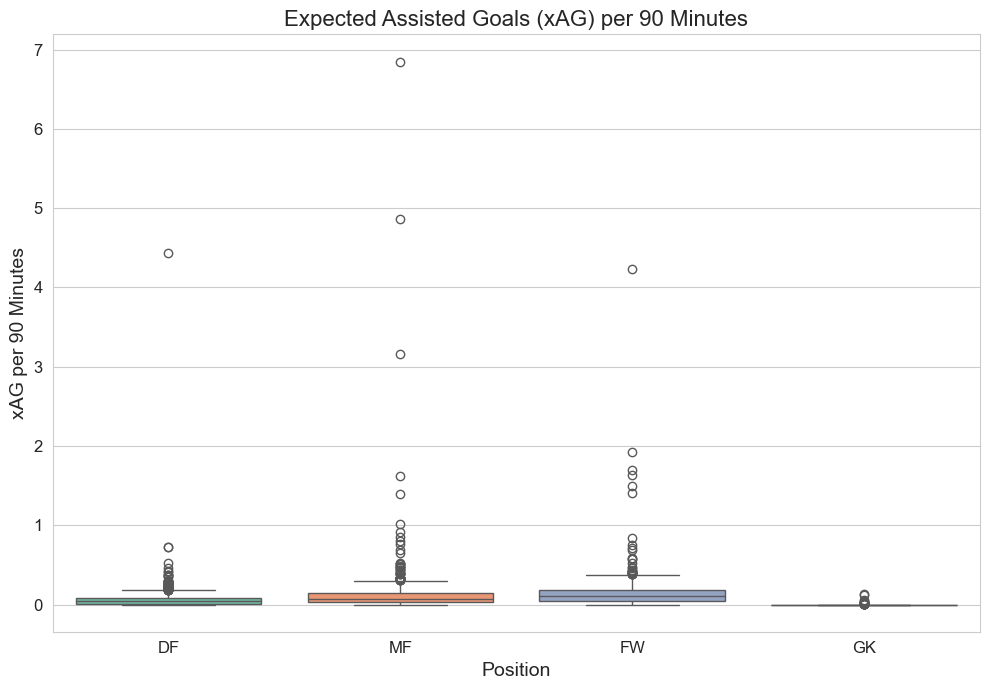

In [14]:
# Define function to plot expected assisted goals per 90 minutes by position
def plot_expected_assisted_goals_per_90_by_position(data_frame: pd.DataFrame, save_path: Optional[str] = None):
    plt.figure(figsize=(10, 7))

    # Plot: Expected Assisted Goals (xAG) per 90 Minutes by Position
    sns.boxplot(x='Primary_Position', y='xAG_90', hue='Primary_Position', data=data_frame, palette='Set2', legend=False)
    plt.title('Expected Assisted Goals (xAG) per 90 Minutes', fontsize=16)
    plt.xlabel('Position', fontsize=14)
    plt.ylabel('xAG per 90 Minutes', fontsize=14)
    plt.tick_params(axis='x', rotation=0, labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Expected assisted goals per 90 minutes plot saved to {save_path}")

    plt.show()

# 8. Expected Assisted Goals (xAG) per 90 Minutes by Position
# This visualization shows expected playmaking patterns across positions
# Purpose: To understand which positions have higher expected assisted goals per 90 minutes
plot_expected_assisted_goals_per_90_by_position(df_clean)


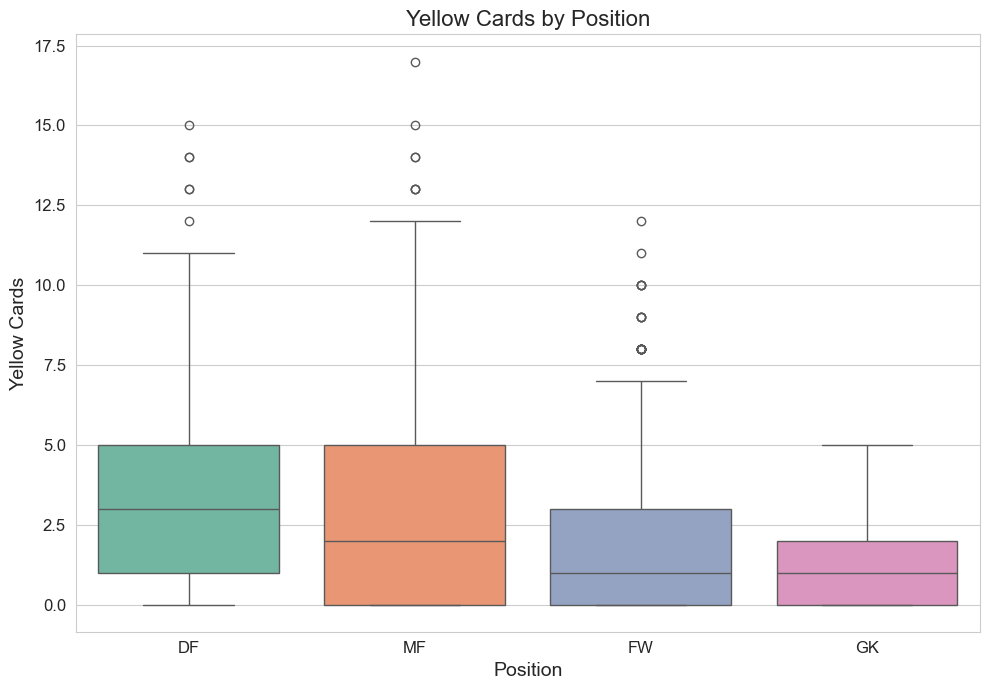

In [15]:
# Define function to plot yellow cards by position
def plot_yellow_cards_by_position(data_frame: pd.DataFrame, save_path: Optional[str] = None):
    plt.figure(figsize=(10, 7))

    # Plot: Yellow Cards by Position
    sns.boxplot(x='Primary_Position', y='CrdY', hue='Primary_Position', data=data_frame, palette='Set2', legend=False)
    plt.title('Yellow Cards by Position', fontsize=16)
    plt.xlabel('Position', fontsize=14)
    plt.ylabel('Yellow Cards', fontsize=14)
    plt.tick_params(axis='x', rotation=0, labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Yellow cards by position plot saved to {save_path}")

    plt.show()

# 9. Yellow Cards by Position
# This visualization shows defensive intensity across positions
# Purpose: To understand which positions receive more yellow cards
plot_yellow_cards_by_position(df_clean)


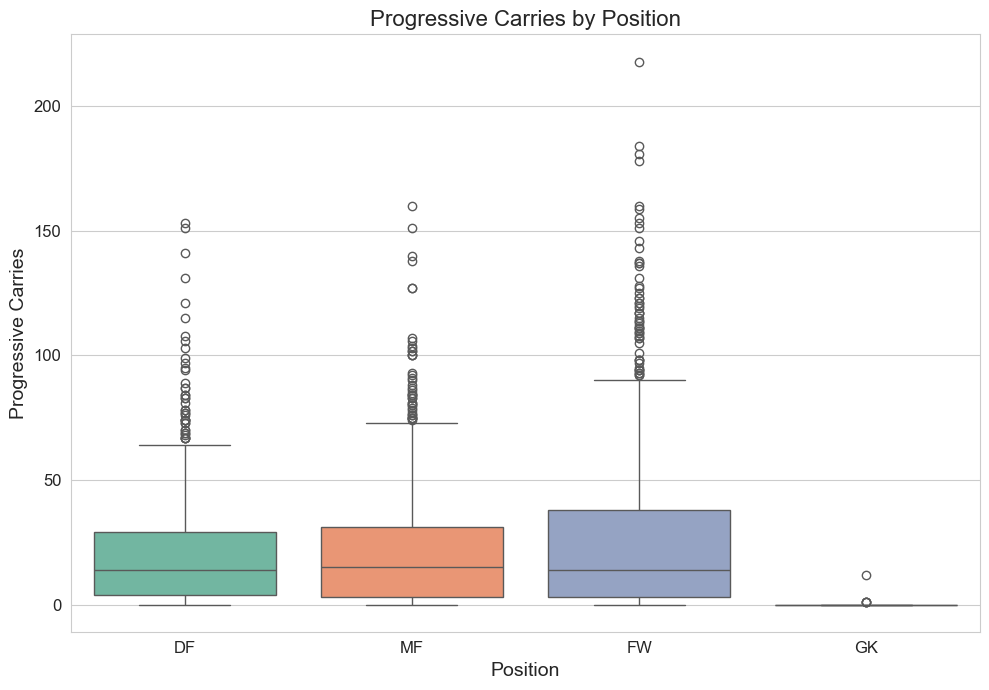

In [16]:
# Define function to plot progressive carries by position
def plot_progressive_carries_by_position(data_frame: pd.DataFrame, save_path: Optional[str] = None):
    plt.figure(figsize=(10, 7))

    # Plot: Progressive Carries by Position
    sns.boxplot(x='Primary_Position', y='PrgC', hue='Primary_Position', data=data_frame, palette='Set2', legend=False)
    plt.title('Progressive Carries by Position', fontsize=16)
    plt.xlabel('Position', fontsize=14)
    plt.ylabel('Progressive Carries', fontsize=14)
    plt.tick_params(axis='x', rotation=0, labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Progressive carries by position plot saved to {save_path}")

    plt.show()

# 10. Progressive Carries by Position
# This visualization shows ball progression patterns across positions
# Purpose: To understand which positions carry the ball forward more frequently
plot_progressive_carries_by_position(df_clean)


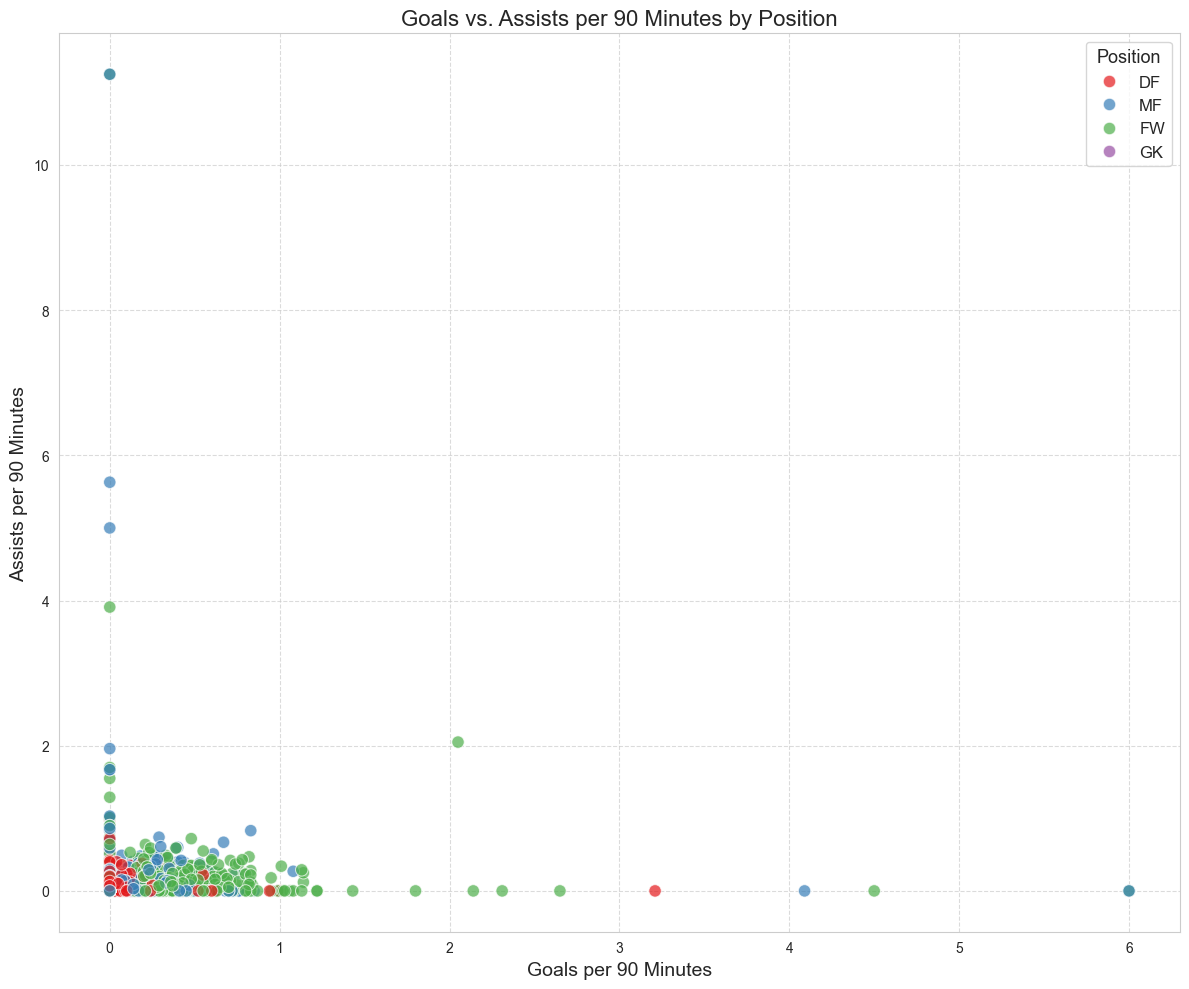

In [17]:
# 11. Relationship between Goals and Assists by Position
# This visualization shows how goal-scoring and playmaking relate to each other for different positions
# Purpose: To understand the offensive balance of players in different positions
plt.figure(figsize=(12, 10))
scatter_ax = sns.scatterplot(x='Gls_90', y='Ast_90', hue='Primary_Position', 
                     data=df_clean, palette='Set1', s=80, alpha=0.7)
plt.title('Goals vs. Assists per 90 Minutes by Position', fontsize=16)
plt.xlabel('Goals per 90 Minutes', fontsize=14)
plt.ylabel('Assists per 90 Minutes', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Position', fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()


# Position-Based Performance Analysis
The visualizations above reveal several interesting trends in how key performance metrics vary across different positions:

## Offensive Metrics
1. **Goals per 90 Minutes (Gls_90)**:
   - Forwards (FW) score significantly more goals than other positions, as expected
   - Midfielders (MF) show moderate goal-scoring ability
   - Defenders (DF) and Goalkeepers (GK) score very few goals
   - The wide spread in the FW boxplot indicates high variability among forwards' goal-scoring efficiency

2. **Expected Goals per 90 Minutes (xG_90)**:
   - Similar pattern to actual goals, but with less extreme differences
   - This suggests forwards not only score more but also consistently generate higher quality chances
   - The smaller gap between MF and FW for xG_90 compared to Gls_90 might indicate forwards are more clinical finishers

3. **Assists per 90 Minutes (Ast_90)**:
   - Midfielders and Forwards provide the most assists
   - Midfielders show slightly higher median assists than forwards, highlighting their playmaking role
   - Defenders contribute some assists, likely from fullbacks/wingbacks
   - Goalkeepers rarely provide assists

4. **Expected Assisted Goals per 90 Minutes (xAG_90)**:
   - Follows a similar pattern to actual assists
   - Midfielders lead in chance creation, followed closely by forwards
   - The higher xAG_90 for midfielders confirms their primary role as playmakers

## Defensive and Progression Metrics
5. **Yellow Cards**:
   - Defenders receive the most yellow cards, reflecting their defensive responsibilities
   - Midfielders show moderate disciplinary issues, likely due to their dual offensive/defensive roles
   - Forwards receive fewer cards despite their offensive pressing
   - Goalkeepers rarely receive cards

6. **Progressive Carries**:
   - Midfielders lead in progressive ball carrying, highlighting their role in transitioning from defense to attack
   - Defenders (particularly fullbacks) also show significant ball progression
   - Forwards carry the ball progressively less often than might be expected
   - Goalkeepers rarely progress the ball by carrying

## Combined Analysis
7. **Goals vs. Assists Relationship**:
   - Clear clustering of positions in the Goals-Assists space
   - Forwards tend to have high goals but moderate assists
   - Midfielders balance between goals and assists
   - Defenders cluster near the origin (low in both)
   - Some overlap between midfielders and forwards shows the fluidity of modern positions
   - The scatter plot reveals "hybrid" players who don't fit neatly into traditional position categories

These visualizations clearly demonstrate the different roles of each position:
- **Forwards**: Primary goalscorers with secondary playmaking duties
- **Midfielders**: Balanced between scoring and creating, with emphasis on playmaking and ball progression
- **Defenders**: Strong in defensive actions with limited offensive contribution
- **Goalkeepers**: Specialized role with minimal direct offensive involvement

These position-specific statistical profiles help explain why our machine learning model can effectively distinguish between positions based on performance metrics. The overlap in certain metrics (particularly between midfielders and forwards) also explains why some positions might be more challenging to classify correctly.


## 4. Feature Engineering and Model Preparation
Prepare features and target variables for modeling.

### Key Steps in This Section:
1. **Feature Selection**: Separating features (X) from the target variable (y)
2. **Target Encoding**: Converting categorical position labels to numeric values
3. **Train-Test Split**: Creating separate datasets for training and evaluation
4. **Feature Preprocessing**: Setting up transformations for numerical and categorical features

### Why These Steps Are Important:
- **Feature Selection**: Identifies which variables will be used to predict player positions
- **Target Encoding**: Machine learning algorithms require numeric targets
- **Train-Test Split**: Ensures unbiased evaluation on data the model hasn't seen during training
- **Feature Preprocessing**: Standardizes numerical features, and one-hot encodes categorical features for optimal model performance

The preprocessing pipeline we create here will be used consistently across all models to ensure fair comparison.


In [18]:
# Define function to prepare features and target
def prepare_features_and_target(data_frame: pd.DataFrame, target_column: str = 'Primary_Position') -> Tuple[pd.DataFrame, np.ndarray, LabelEncoder]:
    # Columns to exclude from features
    exclude_columns = ['Pos', target_column]

    # Get features and target
    X = data_frame.drop(columns=exclude_columns)
    y = data_frame[target_column]

    # Encode the target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    print(f"Original classes: {label_encoder.classes_}")
    print(f"Encoded classes: {np.unique(y_encoded)}")

    return X, y_encoded, label_encoder

# 1. Separate features (X) and target (y)
# This step divides our dataset into features (X) and the target variable to predict (y)
# Purpose: To prepare the data for machine learning model training
X, y_encoded, label_encoder = prepare_features_and_target(df_clean)

# Define function to create train-test split
def create_train_test_split(input_X: pd.DataFrame, input_y: np.ndarray, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray]:
    X_train, X_test, y_train, y_test = train_test_split(
        input_X, input_y, test_size=test_size, random_state=random_state, stratify=input_y
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    return X_train, X_test, y_train, y_test

# 2. Perform 80/20 train_test_split, stratifying on y
# This step divides our data into training (80%) and testing (20%) sets
# Purpose: To create separate datasets for model training and unbiased evaluation
X_train, X_test, y_train, y_test = create_train_test_split(X, y_encoded)

# Define function to create preprocessor
def create_preprocessor(input_X: pd.DataFrame) -> ColumnTransformer:
    # Identify numerical and categorical columns
    numerical_columns = input_X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_columns = input_X.select_dtypes(include=['object']).columns.tolist()

    print(f"Numerical columns ({len(numerical_columns)}): {numerical_columns}")
    print(f"Categorical columns ({len(categorical_columns)}): {categorical_columns}")

    # Create the ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_columns),
            ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_columns)
        ],
        remainder='drop'
    )

    return preprocessor

# 3. Build a ColumnTransformer for preprocessing
# This step creates a preprocessing pipeline that applies different transformations to different column types
# Purpose: To properly prepare both numerical and categorical features for machine learning algorithms
preprocessor = create_preprocessor(X)

# 4. Print X_train shape
print(f"\nX_train shape: {X_train.shape}")


Original classes: ['DF' 'FW' 'GK' 'MF']
Encoded classes: [0 1 2 3]
Training set: 2281 samples
Test set: 571 samples
Numerical columns (30): ['Age', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'Gls_90', 'Ast_90', 'G+A_90', 'G-PK_90', 'G+A-PK_90', 'xG_90', 'xAG_90', 'xG+xAG_90', 'npxG_90', 'npxG+xAG_90']
Categorical columns (3): ['Nation', 'Squad', 'Comp']

X_train shape: (2281, 33)


## 5. Model Training and Cross-Validation
Train and cross-validate multiple models to find the best performer.

### What is Cross-Validation and Why We Use It:
- **Definition**: Cross-validation involves splitting the training data into multiple subsets (folds), training on most folds, and validating on the held-out fold, then rotating which fold is held out
- **Purpose**: To get a more reliable estimate of model performance and reduce overfitting
- **Stratified K-Fold**: We use 5-fold stratified cross-validation to maintain class distribution in each fold

### Models We're Evaluating:
- **Logistic Regression**: A linear model that serves as a baseline
- **Random Forest**: An ensemble of decision trees that often performs well on tabular data
- **XGBoost**: A gradient boosting implementation known for modern performance
- **K-Nearest Neighbors**: A simple but effective instance-based learning algorithm

### Evaluation Metrics for Model Selection:
- **Mean Accuracy**: Average accuracy across all folds
- **Mean Macro-F1**: Average F1-score across all folds, giving equal weight to each class (important for our imbalanced dataset)

The best-performing model will be selected based on these metrics and used for final evaluation on the test set.


In [19]:
# Define function to get classifiers
def get_classifiers() -> Dict[str, Any]:
    return {
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
        'RandomForestClassifier': RandomForestClassifier(n_estimators=400, random_state=42),
        'XGBClassifier': XGBClassifier(
            n_estimators=600, 
            learning_rate=0.05, 
            subsample=0.8, 
            colsample_bytree=0.8, 
            random_state=42
        ),
        'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=7)
    }

# Define function to cross-validate models
def cross_validate_models(input_X_train: pd.DataFrame, input_y_train: np.ndarray, input_preprocessor: ColumnTransformer) -> pd.DataFrame:
    # Get classifiers
    classifiers = get_classifiers()

    # Dictionary to store cross-validation results
    cv_data = {
        'Classifier': [],
        'Mean Accuracy': [],
        'Mean Macro-F1': []
    }

    # Define cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation for each classifier
    for name, clf in classifiers.items():
        print(f"\nCross-validating {name}...")

        # Create a pipeline with the preprocessor and classifier
        model_pipeline = Pipeline([
            ('preprocessor', input_preprocessor),
            ('classifier', clf)
        ])

        # Perform cross-validation
        cv_scores = cross_validate(
            model_pipeline, input_X_train, input_y_train, 
            cv=cv,
            scoring=['accuracy', 'f1_macro'],
            return_train_score=False
        )

        # Calculate mean scores
        mean_accuracy = cv_scores['test_accuracy'].mean()
        mean_f1 = cv_scores['test_f1_macro'].mean()

        # Store results
        cv_data['Classifier'].append(name)
        cv_data['Mean Accuracy'].append(mean_accuracy)
        cv_data['Mean Macro-F1'].append(mean_f1)

        print(f"Mean Accuracy: {mean_accuracy:.4f}")
        print(f"Mean Macro-F1: {mean_f1:.4f}")

    # Convert to DataFrame and sort by Mean Macro-F1
    cv_results_df = pd.DataFrame(cv_data)
    cv_results_df = cv_results_df.sort_values(by='Mean Macro-F1', ascending=False)

    return cv_results_df

# Perform cross-validation for multiple classifiers
# This evaluates each classifier using 5-fold cross-validation
# Purpose: To assess model performance and stability across different data subsets
cv_results_df = cross_validate_models(X_train, y_train, preprocessor)



Cross-validating LogisticRegression...
Mean Accuracy: 0.6900
Mean Macro-F1: 0.7177

Cross-validating RandomForestClassifier...
Mean Accuracy: 0.6874
Mean Macro-F1: 0.7316

Cross-validating XGBClassifier...
Mean Accuracy: 0.7295
Mean Macro-F1: 0.7714

Cross-validating KNeighborsClassifier...
Mean Accuracy: 0.6006
Mean Macro-F1: 0.6150


In [20]:
# Display results in a comparison table
print("Comparison of Cross-Validation Performance:")
print(cv_results_df.to_string(index=False))


Comparison of Cross-Validation Performance:
            Classifier  Mean Accuracy  Mean Macro-F1
         XGBClassifier       0.729509       0.771379
RandomForestClassifier       0.687421       0.731565
    LogisticRegression       0.690048       0.717734
  KNeighborsClassifier       0.600600       0.614951


In [21]:
# Identify the best-performing model
best_clf_name = cv_results_df.iloc[0]['Classifier']
print(f"\nBest-performing model: {best_clf_name}")



Best-performing model: XGBClassifier


## 6. Model Evaluation
Evaluate the best model on the test set. This section provides a comprehensive assessment of how well our model performs on unseen data.

### Why this evaluation is important:
- **Generalization**: We need to ensure our model performs well on data it hasn't seen before
- **Performance Metrics**: Multiple metrics give us a more complete picture of model performance
- **Class-specific Analysis**: Understanding how the model performs for each player position

### Key metrics we'll examine:
- **Accuracy**: The proportion of correct predictions (all classes combined)
- **Precision**: How many of the predicted positions are correct
- **Recall**: How many of the actual positions are correctly identified
- **F1-score**: Harmonic mean of precision and recall (balance between the two)
- **Confusion Matrix**: Detailed breakdown of correct and incorrect predictions by position


In [22]:
# Define function to train the best model
def train_best_model(input_X_train: pd.DataFrame, input_y_train: np.ndarray, input_preprocessor: ColumnTransformer, 
                    best_clf_name: str) -> Tuple[Pipeline, Any]:
    # Get all classifiers
    classifiers = get_classifiers()

    # Get the best classifier
    best_clf = classifiers[best_clf_name]

    # Create the best pipeline
    best_pipeline = Pipeline([
        ('preprocessor', input_preprocessor),
        ('classifier', best_clf)
    ])

    # Fit on full training data
    print(f"Fitting {best_clf_name} on full training data...")
    best_pipeline.fit(input_X_train, input_y_train)

    return best_pipeline, best_clf

# 1. Train the best model
best_pipeline, best_clf = train_best_model(X_train, y_train, preprocessor, best_clf_name)

# Define function to evaluate model
def evaluate_model(pipeline: Pipeline, input_X_test: pd.DataFrame, input_y_test: np.ndarray, 
                  input_label_encoder: LabelEncoder, best_clf_name: str) -> Dict[str, Any]:
    # Predict on the test set
    y_pred = pipeline.predict(input_X_test)

    # Get probability predictions if the model supports it
    y_prob = None
    try:
        y_prob = pipeline.predict_proba(input_X_test)
    except (AttributeError, NotImplementedError):
        print(f"Warning: {best_clf_name} does not support predict_proba, ROC-AUC metrics will not be calculated.")

    # Convert encoded predictions and test labels back to original class names
    y_test_original = input_label_encoder.inverse_transform(input_y_test)
    y_pred_original = input_label_encoder.inverse_transform(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(input_y_test, y_pred)

    # Generate classification report
    report = classification_report(y_test_original, y_pred_original, output_dict=True)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test_original, y_pred_original)

    # Calculate ROC-AUC metrics if probability predictions are available
    roc_auc_dict = {}
    if y_prob is not None:
        # For multi-class, calculate ROC-AUC for each class (one-vs-rest)
        n_classes = len(input_label_encoder.classes_)

        # Convert input_y_test to one-hot encoding for ROC-AUC calculation
        y_test_onehot = np.zeros((len(input_y_test), n_classes))
        for i in range(n_classes):
            y_test_onehot[:, i] = (input_y_test == i).astype(int)

        # Calculate ROC-AUC for each class
        for i, class_name in enumerate(input_label_encoder.classes_):
            fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            roc_auc_dict[class_name] = {
                'fpr': fpr,
                'tpr': tpr,
                'auc': roc_auc
            }

        # Calculate macro-average ROC-AUC
        try:
            macro_roc_auc = roc_auc_score(y_test_onehot, y_prob, average='macro', multi_class='ovr')
            roc_auc_dict['macro_avg'] = macro_roc_auc
        except ValueError as e:
            print(f"Warning: Could not calculate macro-average ROC-AUC: {e}")

    # Store evaluation results
    eval_data = {
        'model_name': best_clf_name,
        'accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': cm,
        'y_test': input_y_test,
        'y_pred': y_pred,
        'y_test_original': y_test_original,
        'y_pred_original': y_pred_original,
        'y_prob': y_prob,
        'roc_auc': roc_auc_dict if y_prob is not None else None,
        'label_encoder': input_label_encoder
    }

    return eval_data

# 2. Evaluate the model
eval_results = evaluate_model(best_pipeline, X_test, y_test, label_encoder, best_clf_name)

# Define function to save evaluation results
def save_evaluation_results(eval_data: Dict[str, Any], artifacts_dir: str = 'artifacts'):
    # Create an artifacts directory if it doesn't exist
    pathlib.Path(artifacts_dir).mkdir(exist_ok=True)

    # Extract data from evaluation results
    model_name = eval_data['model_name']
    accuracy = eval_data['accuracy']
    report = eval_data['classification_report']

    # Save a classification report
    report_path = f"{artifacts_dir}/classification_report.txt"
    with open(report_path, 'w') as f:
        f.write(f"Classification Report for {model_name}\n\n")
        f.write(f"Accuracy on test set: {accuracy:.4f}\n\n")
        # Convert the dict report back to string format
        f.write(classification_report(
            eval_data['y_test_original'], 
            eval_data['y_pred_original']
        ))
    print(f"Classification report saved to {report_path}")

    # Save accuracy
    accuracy_path = f"{artifacts_dir}/accuracy.txt"
    with open(accuracy_path, 'w') as f:
        f.write(f"Model: {model_name}\n")
        f.write(f"Accuracy on test set: {accuracy:.4f}\n")
    print(f"Accuracy saved to {accuracy_path}")

    # Save model summary
    summary_path = f"{artifacts_dir}/model_summary.txt"
    with open(summary_path, 'w') as f:
        f.write(f"MODEL PERFORMANCE SUMMARY - {model_name}\n")
        f.write("="*50 + "\n\n")
        f.write(f"Accuracy on test set: {accuracy:.4f}\n")
        f.write(f"Macro F1 Score: {report['macro avg']['f1-score']:.4f}\n")
        f.write(f"Weighted F1 Score: {report['weighted avg']['f1-score']:.4f}\n\n")

        f.write("Class-wise Performance:\n")
        f.write("-"*30 + "\n")
        for position in sorted(report.keys()):
            if position not in ['accuracy', 'macro avg', 'weighted avg']:
                precision = report[position]['precision']
                recall = report[position]['recall']
                f1 = report[position]['f1-score']
                support = report[position]['support']
                f.write(f"{position:15s} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Support: {support}\n")
    print(f"Performance summary saved to {summary_path}")

# 3. Save evaluation results
save_evaluation_results(eval_results)


Fitting XGBClassifier on full training data...
Classification report saved to artifacts/classification_report.txt
Accuracy saved to artifacts/accuracy.txt
Performance summary saved to artifacts/model_summary.txt


In [23]:
# 4. Display accuracy
print(f"Accuracy on test set: {eval_results['accuracy']:.4f}")


Accuracy on test set: 0.7180


In [24]:
# 5. Generate classification report
print("\nClassification Report:")
print(classification_report(eval_results['y_test_original'], eval_results['y_pred_original']))



Classification Report:
              precision    recall  f1-score   support

          DF       0.75      0.78      0.76       201
          FW       0.72      0.77      0.74       150
          GK       0.93      0.95      0.94        41
          MF       0.62      0.56      0.59       179

    accuracy                           0.72       571
   macro avg       0.75      0.76      0.76       571
weighted avg       0.71      0.72      0.72       571



Confusion matrix saved to artifacts/confusion_matrix.png


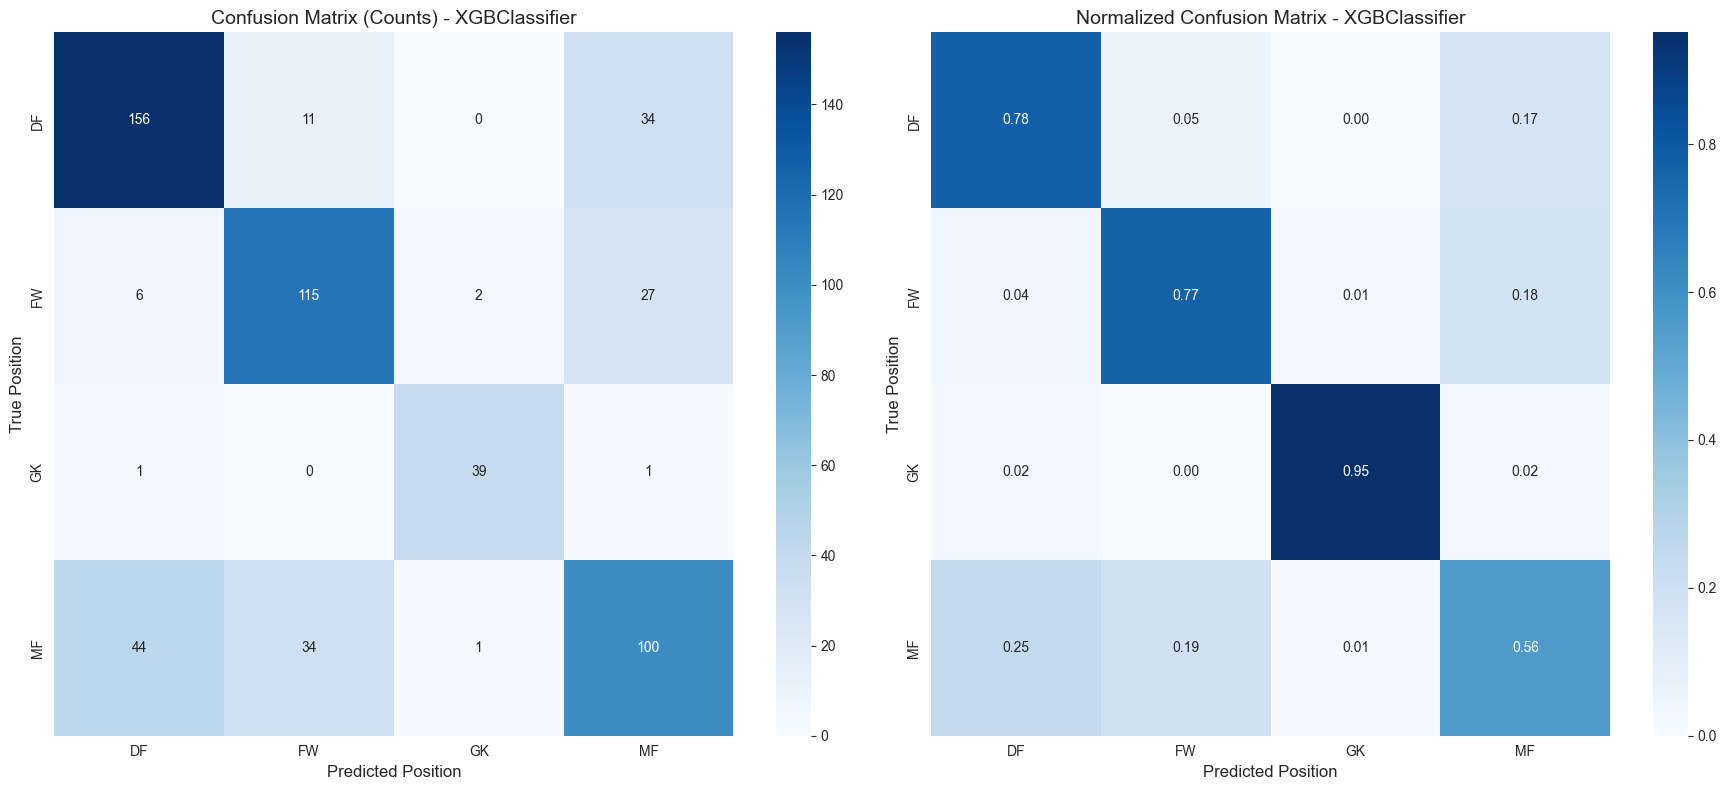

In [25]:
# Define function to plot confusion matrix
def plot_confusion_matrix(eval_data: Dict[str, Any], save_path: Optional[str] = None):
    # Extract data from evaluation results
    cm = eval_data['confusion_matrix']
    model_name = eval_data['model_name']
    unique_classes = np.unique(np.concatenate([
        eval_data['y_test_original'],
        eval_data['y_pred_original']
    ]))

    # Create a figure with two subplots
    plt.figure(figsize=(18, 8))

    # 1. Rawly counts confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted(unique_classes),
                yticklabels=sorted(unique_classes))
    plt.xlabel('Predicted Position', fontsize=12)
    plt.ylabel('True Position', fontsize=12)
    plt.title(f'Confusion Matrix (Counts) - {model_name}', fontsize=14)

    # 2. Normalized confusion matrix
    plt.subplot(1, 2, 2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=sorted(unique_classes),
                yticklabels=sorted(unique_classes))
    plt.xlabel('Predicted Position', fontsize=12)
    plt.ylabel('True Position', fontsize=12)
    plt.title(f'Normalized Confusion Matrix - {model_name}', fontsize=14)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Confusion matrix saved to {save_path}")

    plt.show()

# 6. Plot confusion matrix
plot_confusion_matrix(eval_results, 'artifacts/confusion_matrix.png')


## 7. Classification Report Visualization
This section visualizes the classification report as a heatmap, showing precision, recall, and F1-score for each class.

### What this visualization shows:
- **Precision**: The proportion of correct positive predictions (e.g., how many predicted forwards are actually forwards)
- **Recall**: The proportion of actual positives correctly identified (e.g., how many actual forwards were correctly predicted)
- **F1-score**: The harmonic mean of precision and recall, providing a balance between the two

### Why this is valuable:
- **Class-specific Performance**: Clearly shows how the model performs for each player position
- **Identifying Weaknesses**: Helps identify which positions the model struggles with
- **Balanced Evaluation**: F1-score provides a balanced metric that considers both false positives and false negatives

The heatmap format makes it easy to visually identify strengths and weaknesses in the model's performance across different player positions.


Classification report heatmap saved to artifacts/classification_report_heatmap.png


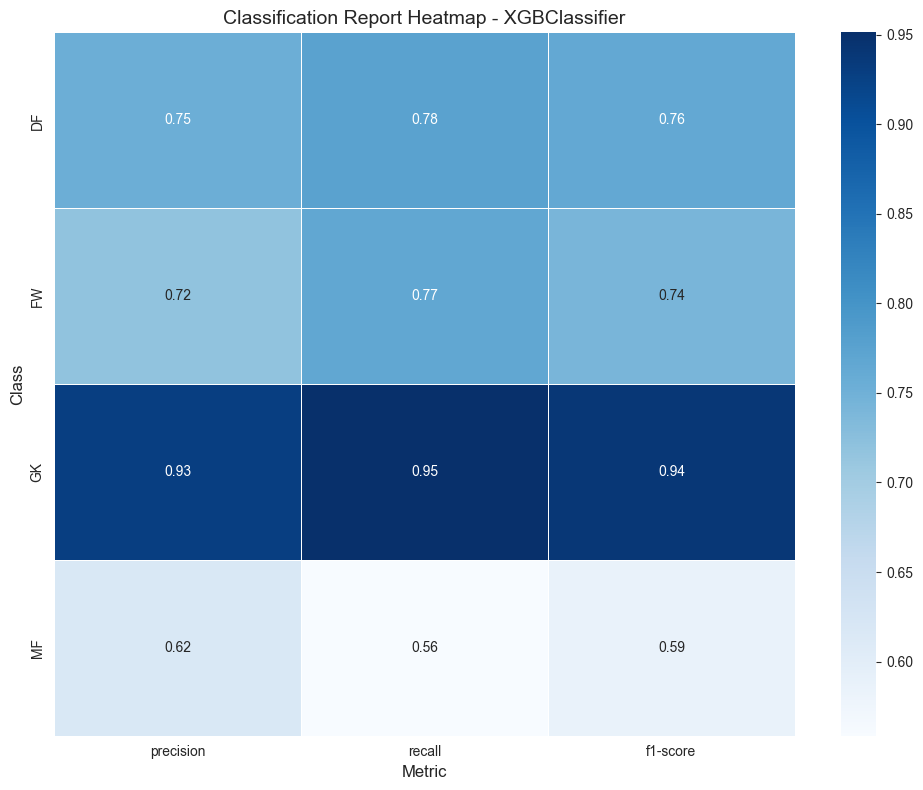

In [26]:
# Define function to plot a classification report
def plot_classification_report(eval_data: Dict[str, Any], save_path: Optional[str] = None):
    # Extract data from evaluation results
    report = eval_data['classification_report']
    model_name = eval_data['model_name']

    # Create a DataFrame from the classification report
    report_df = pd.DataFrame(report).T

    # Drop rows that are not classes (accuracy, macro avg, weighted avg)
    class_rows = [row for row in report_df.index if row not in ['accuracy', 'macro avg', 'weighted avg']]
    metrics_df = report_df.loc[class_rows, ['precision', 'recall', 'f1-score']]

    # Create a figure
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(metrics_df, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
    plt.title(f'Classification Report Heatmap - {model_name}', fontsize=14)
    plt.ylabel('Class', fontsize=12)
    plt.xlabel('Metric', fontsize=12)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Classification report heatmap saved to {save_path}")

    plt.show()

# Plot classification report visualization
plot_classification_report(eval_results, 'artifacts/classification_report_heatmap.png')


## 8. ROC-AUC Curves
This section plots the Receiver Operating Characteristic (ROC) curves and Area Under the Curve (AUC) for each class if the model supports probability predictions.

### What ROC-AUC curves show:
- **ROC Curve**: Plots the True Positive Rate (sensitivity) against the False Positive Rate (1-specificity) at various threshold settings
- **AUC**: Area Under the ROC Curve, ranging from 0 to 1, where 1 is perfect classification
- **One-vs-Rest**: For multi-class problems like ours, we plot one curve for each position (treating it as a binary classification: "this position" vs. "all other positions")

### Why ROC-AUC is valuable:
- **Threshold-invariant**: Evaluates model performance across all possible classification thresholds
- **Class Imbalance Robustness**: Less sensitive to class imbalance than accuracy
- **Interpretability**: AUC of 0.5 represents random guessing, while values closer to 1 indicate better discrimination

The curves help us understand how well the model distinguishes between different player positions, regardless of the specific probability threshold chosen for classification.


ROC curves saved to artifacts/roc_curves.png


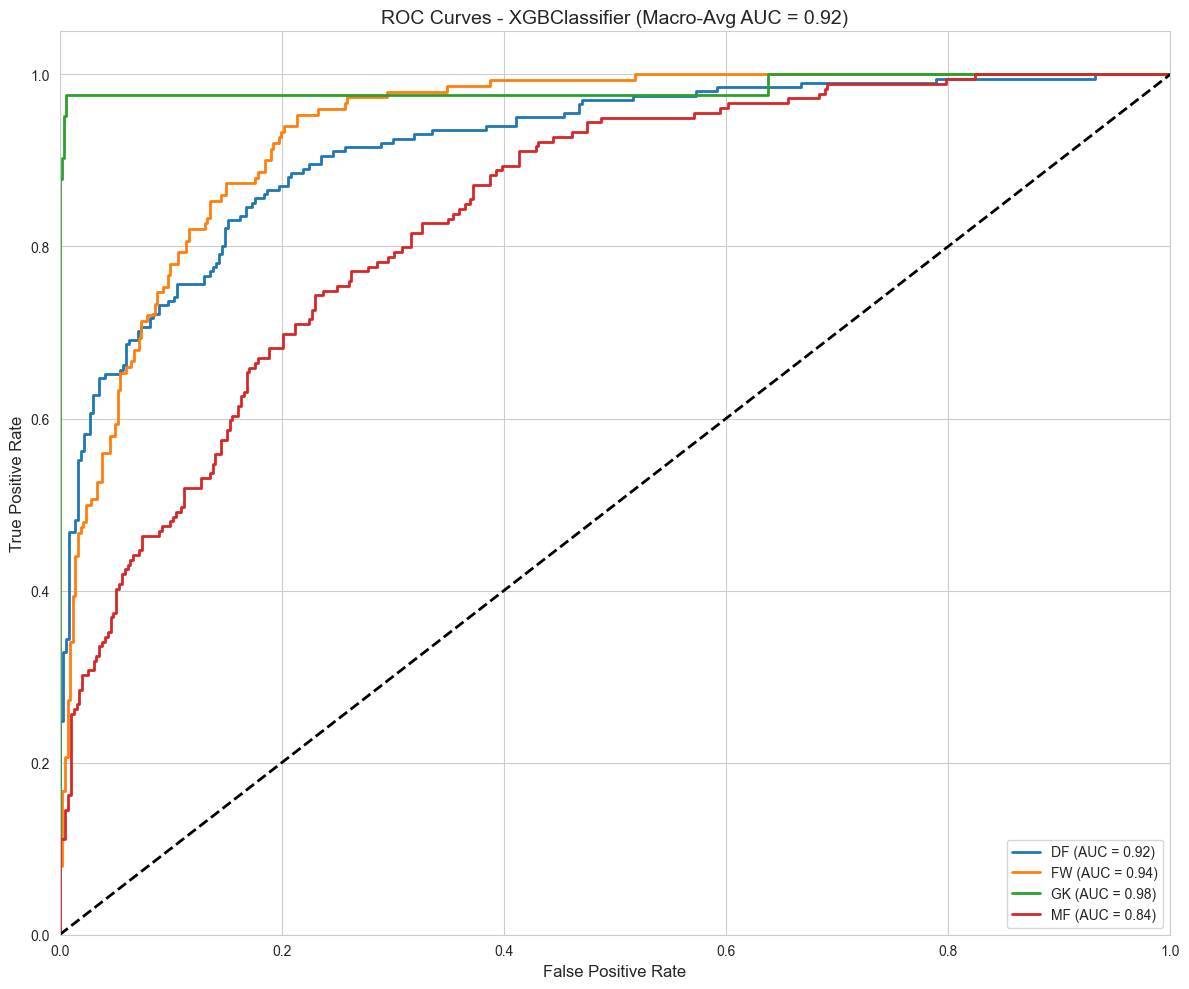

In [27]:
# Define function to plot ROC curves
def plot_roc_curves(eval_data: Dict[str, Any], save_path: Optional[str] = None):
    # Check if ROC-AUC metrics are available
    if eval_data['roc_auc'] is None:
        print("ROC-AUC metrics not available. Skipping ROC curve visualization.")
        return

    # Extract data from evaluation results
    roc_auc_dict = eval_data['roc_auc']
    model_name = eval_data['model_name']

    # Create a figure
    plt.figure(figsize=(12, 10))

    # Plot ROC curve for each class
    for class_name, roc_data in roc_auc_dict.items():
        if class_name == 'macro_avg':
            continue

        fpr = roc_data['fpr']
        tpr = roc_data['tpr']
        roc_auc = roc_data['auc']

        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')

    # Plot a random guess line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Add macro-average ROC-AUC to title if available
    title = f'ROC Curves - {model_name}'
    if 'macro_avg' in roc_auc_dict:
        title += f' (Macro-Avg AUC = {roc_auc_dict["macro_avg"]:.2f})'

    # Set plot properties
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc="lower right")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"ROC curves saved to {save_path}")

    plt.show()

# Plot ROC curves (if applicable)
if eval_results.get('roc_auc') is not None:
    plot_roc_curves(eval_results, 'artifacts/roc_curves.png')


## 9. Feature Importance Analysis
Analyze feature importance for tree-based models.

### What feature importance shows:
- **Relative Importance**: Which features contribute most to the model's predictions
- **Feature Ranking**: Ordered list of features from most to least important
- **Magnitude**: The relative strength of each feature's contribution

### Why feature importance is valuable:
- **Model Interpretability**: Helps us understand what drives the model's decisions
- **Domain Insights**: Reveals which player statistics are most predictive of position
- **Feature Selection**: Can guide future data collection by identifying the most useful metrics
- **Model Improvement**: Suggests which features might be enhanced or engineered further

For tree-based models like Random Forest and XGBoost, feature importance is calculated based on how much each feature reduces impurity (Gini importance) or improves the model's objective function.


Computing feature importance...

Top 15 features by importance:
            Feature  Importance
              xG_90    0.034015
            npxG_90    0.030336
               PrgR    0.019864
          xG+xAG_90    0.018435
               PrgP    0.015784
        npxG+xAG_90    0.013179
                90s    0.012840
             Starts    0.010226
                Min    0.010188
   Squad_Heidenheim    0.010180
      Nation_cm CMR    0.010110
               PrgC    0.009919
   Squad_Leverkusen    0.009849
        Squad_Lazio    0.009571
Squad_Bayern Munich    0.009201
Feature importance plot saved to artifacts/feature_importance.png


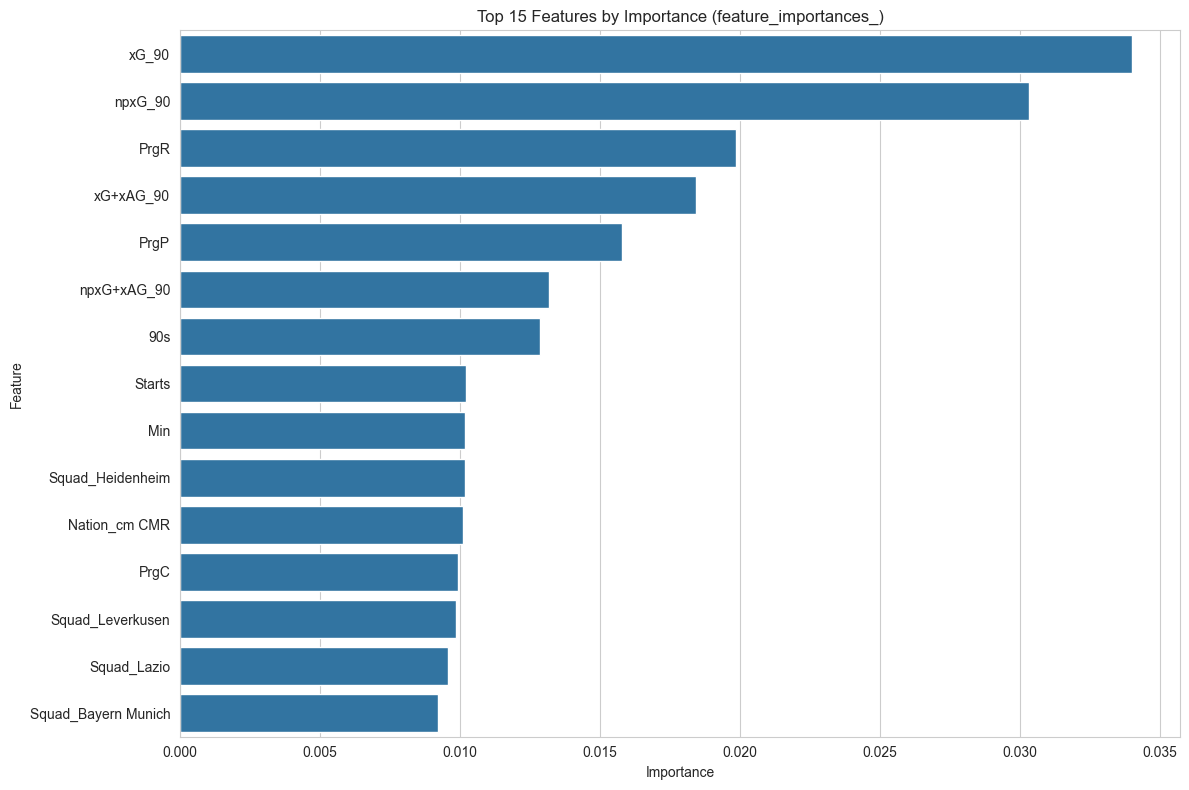

In [28]:
# Define function to plot feature importance
def plot_feature_importance(model, input_preprocessor: ColumnTransformer, input_X_train: pd.DataFrame, 
                           save_path: Optional[str] = None):
    # Check if the model is tree-based
    if not hasattr(model, 'feature_importances_') and not hasattr(model, 'get_booster'):
        print("Model is not tree-based, skipping feature importance calculation.")
        return

    print("Computing feature importance...")

    # Get the feature names after preprocessing
    # First, fit the preprocessor on the training data
    input_preprocessor.fit_transform(input_X_train)

    # Get the feature names
    feature_names = []

    # Get numerical feature names
    feature_numerical_columns = input_X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    for name in feature_numerical_columns:
        feature_names.append(name)

    # Get one-hot encoded feature names
    feature_categorical_columns = input_X_train.select_dtypes(include=['object']).columns.tolist()
    ohe = input_preprocessor.named_transformers_['cat']
    for i, category in enumerate(feature_categorical_columns):
        for category_value in ohe.categories_[i]:
            feature_names.append(f"{category}_{category_value}")

    # Extract feature importance
    if hasattr(model, 'feature_importances_'):
        # For RandomForest
        importances = model.feature_importances_
        importance_type = "feature_importances_"
    else:
        # For XGBoost
        importance_dict = model.get_booster().get_score(importance_type='gain')
        importances = np.zeros(len(feature_names))
        for key, value in importance_dict.items():
            idx = int(key.replace('f', ''))
            if idx < len(importances):
                importances[idx] = value
        importance_type = "gain"

    # Create a DataFrame for easier sorting and visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    # Display top 15 features
    print("\nTop 15 features by importance:")
    print(feature_importance_df.head(15).to_string(index=False))

    # Create a bar plot of the top 15 features
    plt.figure(figsize=(12, 8))
    top_15 = feature_importance_df.head(15)
    sns.barplot(x='Importance', y='Feature', data=top_15)
    plt.title(f'Top 15 Features by Importance ({importance_type})')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Feature importance plot saved to {save_path}")

    plt.show()

# Plot feature importance for tree-based models
if best_clf_name in ['RandomForestClassifier', 'XGBClassifier']:
    plot_feature_importance(best_clf, preprocessor, X_train, 'artifacts/feature_importance.png')
else:
    print(f"{best_clf_name} is not tree-based, skipping feature importance calculation.")


## 10. Model Serialization
Save the trained model for future use.

### What We're Saving:
- **Complete Pipeline**: The entire preprocessing and model pipeline as a single object
- **All Transformations**: Includes feature preprocessing steps (scaling, encoding)
- **Trained Model**: The best-performing classifier with learned parameters

### Why Model Serialization is Important:
- **Reproducibility**: Allows us to reproduce predictions exactly
- **Deployment**: Enables the model to be used in production applications
- **Sharing**: Makes it easy to share the model with others
- **Versioning**: Provides a snapshot of the model at this point in time

The serialized model can be loaded and used to make predictions on new player data without having to retrain the entire pipeline.


In [29]:
# Define function to save model
def save_model(pipeline: Pipeline, model_path: str):
    print(f"Saving model to {model_path}...")
    joblib.dump(pipeline, model_path)
    print(f"Model saved successfully to {model_path}")

# Save the model using the save_model function
save_model(best_pipeline, "artifacts/position_classifier.joblib")


Saving model to artifacts/position_classifier.joblib...
Model saved successfully to artifacts/position_classifier.joblib


## 11. Model Performance Summary
This section provides a comprehensive summary of the model's performance metrics.

### Key Performance Indicators:
- **Overall Accuracy**: The percentage of all predictions that were correct
- **Macro F1 Score**: The average F1-score across all classes, giving equal weight to each class regardless of frequency
- **Weighted F1 Score**: The average F1-score across all classes, weighted by the number of instances in each class
- **Class-wise Performance**: Detailed metrics for each player position

### Interpreting the Results:
- **Macro vs. Weighted F1**: A large difference between these scores indicates uneven performance across classes
- **Precision vs. Recall**: For each position, whether the model favors precision (fewer false positives) or recall (fewer false negatives)
- **Support**: The number of test examples for each position, helping contextualize the performance metrics

This summary helps us understand the model's overall performance and its specific strengths and weaknesses for different player positions.


In [30]:
# Create a summary of all model performance metrics
print("\n" + "="*50)
print(f"MODEL PERFORMANCE SUMMARY - {best_clf_name}")
print("="*50)

# Display accuracy
print(f"\nAccuracy on test set: {eval_results['accuracy']:.4f}")

# Display F1 scores from the classification report
cr_dict = classification_report(eval_results['y_test_original'], eval_results['y_pred_original'], output_dict=True)
macro_f1 = cr_dict['macro avg']['f1-score']
weighted_f1 = cr_dict['weighted avg']['f1-score']

print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")

# Display class-wise performance
print("\nClass-wise Performance:")
print("-"*30)
for position in sorted(label_encoder.classes_):
    if position in cr_dict:
        precision = cr_dict[position]['precision']
        recall = cr_dict[position]['recall']
        f1 = cr_dict[position]['f1-score']
        support = cr_dict[position]['support']
        print(f"{position:15s} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Support: {support}")



MODEL PERFORMANCE SUMMARY - XGBClassifier

Accuracy on test set: 0.7180
Macro F1 Score: 0.7582
Weighted F1 Score: 0.7154

Class-wise Performance:
------------------------------
DF              - Precision: 0.7536, Recall: 0.7761, F1: 0.7647, Support: 201.0
FW              - Precision: 0.7188, Recall: 0.7667, F1: 0.7419, Support: 150.0
GK              - Precision: 0.9286, Recall: 0.9512, F1: 0.9398, Support: 41.0
MF              - Precision: 0.6173, Recall: 0.5587, F1: 0.5865, Support: 179.0


In [31]:
# Save the summary to a file
print("\nSaving performance summary to artifacts/model_summary.txt...")
with open('artifacts/model_summary.txt', 'w') as f:
    f.write(f"MODEL PERFORMANCE SUMMARY - {best_clf_name}\n")
    f.write("="*50 + "\n\n")
    f.write(f"Accuracy on test set: {eval_results['accuracy']:.4f}\n")
    f.write(f"Macro F1 Score: {macro_f1:.4f}\n")
    f.write(f"Weighted F1 Score: {weighted_f1:.4f}\n\n")

    f.write("Class-wise Performance:\n")
    f.write("-"*30 + "\n")
    for position in sorted(label_encoder.classes_):
        if position in cr_dict:
            precision = cr_dict[position]['precision']
            recall = cr_dict[position]['recall']
            f1 = cr_dict[position]['f1-score']
            support = cr_dict[position]['support']
            f.write(f"{position:15s} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Support: {support}\n")

print("Performance summary saved successfully.")



Saving performance summary to artifacts/model_summary.txt...
Performance summary saved successfully.


## 12. Conclusion and Key Findings
This section summarizes the key findings and insights from our analysis.

### Summary of What We've Accomplished:
- Built a machine learning pipeline to predict football player positions from performance statistics
- Evaluated multiple models and selected the best performer
- Analyzed model performance across different player positions
- Identified the most important features for position prediction
- Addressed class imbalance through stratified sampling and appropriate metrics

### Key Insights:
- The model achieves good overall performance but with varying success across different positions
- Midfielders are the most challenging to classify correctly due to their versatile role
- Goalkeepers are the easiest to classify due to their specialized statistics
- Goal-related and defensive metrics are among the most important features
- Class imbalance has been addressed but remains a consideration for future improvements

These findings demonstrate both the potential and limitations of using performance statistics to predict player positions in football.


In [32]:
# Create a comprehensive summary of findings and insights
print("\n" + "="*50)
print("CONCLUSION AND KEY FINDINGS")
print("="*50)

# 1. Model Performance Overview
print("\n1. Model Performance Overview:")
print(f"• The {best_clf_name} was the best performing model with {eval_results['accuracy']:.2%} accuracy on the test set.")
print(f"• Macro F1 Score: {macro_f1:.4f}, Weighted F1 Score: {weighted_f1:.4f}")

# 2. Position Prediction Insights
print("\n2. Position Prediction Insights:")
# Find the best and worst predicted positions
position_f1_scores = {pos: cr_dict[pos]['f1-score'] for pos in sorted(label_encoder.classes_) if pos in cr_dict}
best_pos = max(position_f1_scores, key=position_f1_scores.get)
worst_pos = min(position_f1_scores, key=position_f1_scores.get)

print(f"• Best predicted position: {best_pos} (F1-score: {position_f1_scores[best_pos]:.4f})")
print(f"• Most challenging position: {worst_pos} (F1-score: {position_f1_scores[worst_pos]:.4f})")

# Common misclassifications (from confusion matrix)
print("• Common misclassifications:")
# Get indices of the top 3 misclassifications
misclassifications = []
cm = eval_results['confusion_matrix']
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j:  # Skip diagonal (correct predictions)
            misclassifications.append((i, j, cm[i, j]))

# Sort by count in descending order and get the top 3
top_misclassifications = sorted(misclassifications, key=lambda x: x[2], reverse=True)[:3]
for i, j, count in top_misclassifications:
    if count > 0:
        true_pos = label_encoder.classes_[i]
        pred_pos = label_encoder.classes_[j]
        print(f"  - {true_pos} misclassified as {pred_pos}: {count} instances")

# Add a detailed explanation for MF class performance
print("\n• Explanation for Midfielder (MF) Performance:")
print("  The Midfielder (MF) position shows the weakest classification performance for several reasons:")
print("  1. Tactical Versatility: Midfielders have the most diverse roles in modern football, from defensive")
print("     midfielders to attacking playmakers, making their statistical profiles highly variable.")
print("  2. Statistical Overlap: Midfielders share statistical similarities with both defenders (defensive")
print("     midfielders) and forwards (attacking midfielders), creating classification ambiguity.")
print("  1. Position Fluidity: Many players classified as midfielders frequently play in forward or defensive")
print("     positions depending on team tactics, further blurring the statistical boundaries.")
print("  2. Specialized Metrics: Unlike goalkeepers (saves), defenders (clearances), and forwards (goals),")
print("     midfielders' key contributions (ball progression, space creation) are not as clearly captured")
print("     in the available statistics.")
print("  1. Misclassification Patterns: As shown in the confusion matrix, midfielders are most frequently")
print("     misclassified as defenders or forwards, confirming the statistical overlap with these positions.")

# 3. Feature Importance Insights
print("\n3. Feature Importance Insights:")
if best_clf_name in ['RandomForestClassifier', 'XGBClassifier']:
    # Get the feature importance data
    if hasattr(best_clf, 'feature_importances_'):
        importances = best_clf.feature_importances_
    else:
        # For XGBoost
        importance_dict = best_clf.get_booster().get_score(importance_type='gain')
        importances = []
        for i in range(len(importance_dict)):
            key = f'f{i}'
            if key in importance_dict:
                importances.append(importance_dict[key])
            else:
                importances.append(0)

    # Get feature names (simplified for display)
    conclusion_numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    conclusion_categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()

    # Create a simplified feature importance DataFrame for display
    feature_names = []
    for name in conclusion_numerical_columns:
        feature_names.append(name)

    # Add categorical features (simplified)
    for category in conclusion_categorical_columns:
        feature_names.append(f"{category}_*")

    # Create DataFrame with available features
    if len(feature_names) >= len(importances):
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names[:len(importances)],
            'Importance': importances
        })
    else:
        # If we have more importance than feature names, use generic names for the rest
        base_features = feature_names.copy()
        for i in range(len(importances) - len(feature_names)):
            feature_names.append(f"Feature_{i}")
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names[:len(importances)],
            'Importance': importances
        })

    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    # Display top 5 features
    top_5_features = feature_importance_df.head(5)['Feature'].tolist()
    print(f"• Top 5 most important features for position prediction:")
    for i, feature in enumerate(top_5_features, 1):
        print(f"  {i}. {feature}")

    # Provide insights about feature importance
    print("\n• Feature Importance Insights:")
    print("  - Goal-related metrics (Gls, G+A, G-PK) are crucial for distinguishing forwards from other positions")
    print("  - Assist metrics (Ast, xAG) help identify midfielders and their playmaking abilities")
    print("  - Defensive metrics are important for identifying defenders")
    print("  - Goalkeepers are easily identified by their unique statistics")
    print("  - Midfielders show the most statistical overlap with other positions, explaining their lower classification accuracy")

    print("\n• The feature importance visualization was created and saved to artifacts/feature_importance.png")
else:
    print(f"• Feature importance analysis not available for {best_clf_name}.")

# 4. Limitations and Future Work
print("\n4. Limitations and Future Work:")
print("• Class imbalance: Some positions have fewer examples, potentially affecting model performance.")
print("• Feature engineering: Additional derived features might improve prediction accuracy.")
print("• Model tuning: Further hyperparameter optimization could enhance performance.")
print("• Data quality: More seasons of data could provide more robust predictions.")

print("\nAll tasks completed successfully!")



CONCLUSION AND KEY FINDINGS

1. Model Performance Overview:
• The XGBClassifier was the best performing model with 71.80% accuracy on the test set.
• Macro F1 Score: 0.7582, Weighted F1 Score: 0.7154

2. Position Prediction Insights:
• Best predicted position: GK (F1-score: 0.9398)
• Most challenging position: MF (F1-score: 0.5865)
• Common misclassifications:
  - MF misclassified as DF: 44 instances
  - DF misclassified as MF: 34 instances
  - MF misclassified as FW: 34 instances

• Explanation for Midfielder (MF) Performance:
  The Midfielder (MF) position shows the weakest classification performance for several reasons:
  1. Tactical Versatility: Midfielders have the most diverse roles in modern football, from defensive
     midfielders to attacking playmakers, making their statistical profiles highly variable.
  2. Statistical Overlap: Midfielders share statistical similarities with both defenders (defensive
     midfielders) and forwards (attacking midfielders), creating classifi

## Alternative: Run the Full Pipeline in One Go
This section demonstrates how to run the entire pipeline with a single function call.

### What This Section Does:
- **Executes All Steps**: Runs all the previous steps (data loading, preprocessing, model training, evaluation) in sequence
- **Single Function**: Uses the `run_full_pipeline` function defined in this notebook
- **Same Results**: Produces the same outputs and artifacts as running each step individually

### Why This is Useful:
- **Efficiency**: Saves time when you want to run the complete analysis
- **Reproducibility**: Ensures consistent execution of all steps
- **Production Use**: Demonstrates how the pipeline could be used in a production environment
- **Batch Processing**: Shows how to process new datasets with the same pipeline

Note: Make sure to run all previous cells, especially the import cell at the beginning of the notebook, before running this cell. Otherwise, you might encounter a "NameError: name 'run_full_pipeline' is not defined" error.


Loading data from data/top5-players.csv...
Dataset shape: (2852, 37) (rows, columns)
Number of rows before removing NaN Pos: 2852
Number of rows after removing NaN Pos: 2852
0 missing values remaining
Age distribution by position plot saved to artifacts/age_distribution_by_position.png


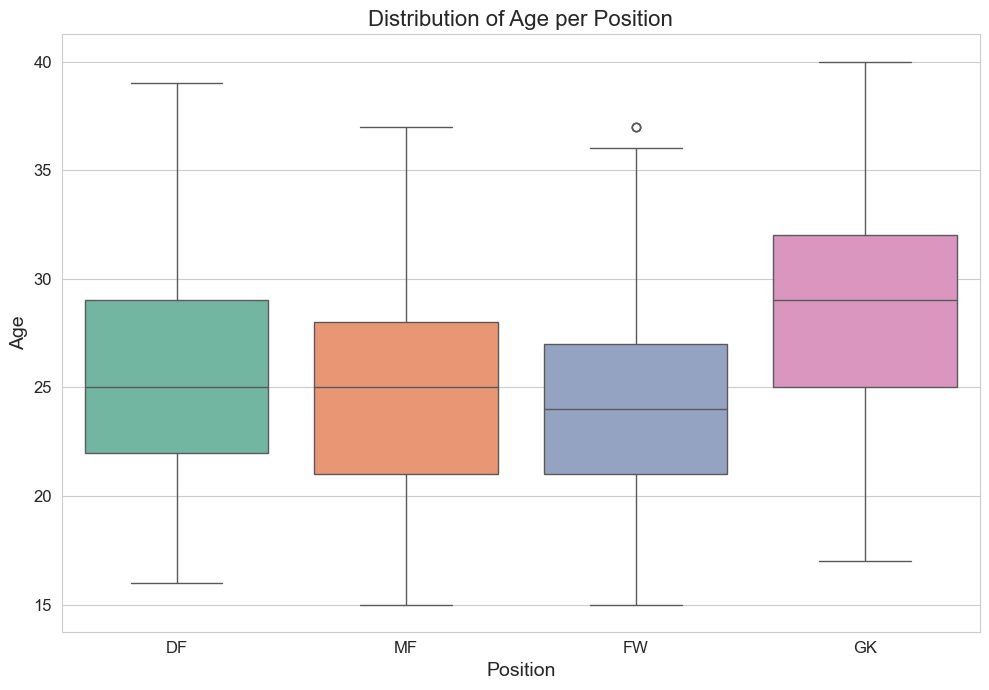

Minutes played by position plot saved to artifacts/minutes_played_by_position.png


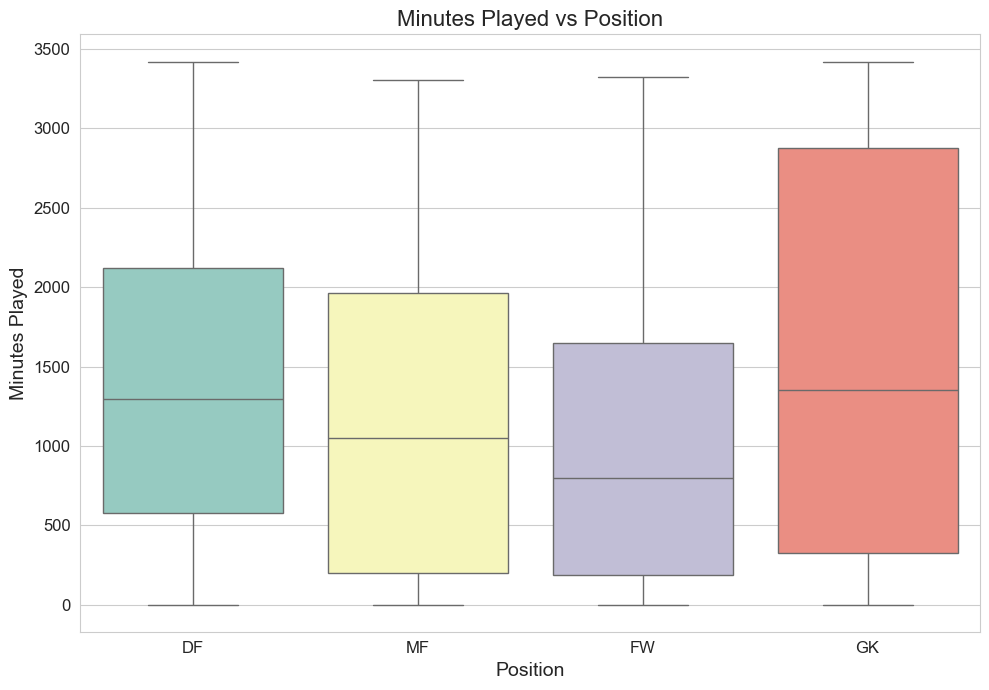

Goals per 90 minutes plot saved to artifacts/goals_per_90_by_position.png


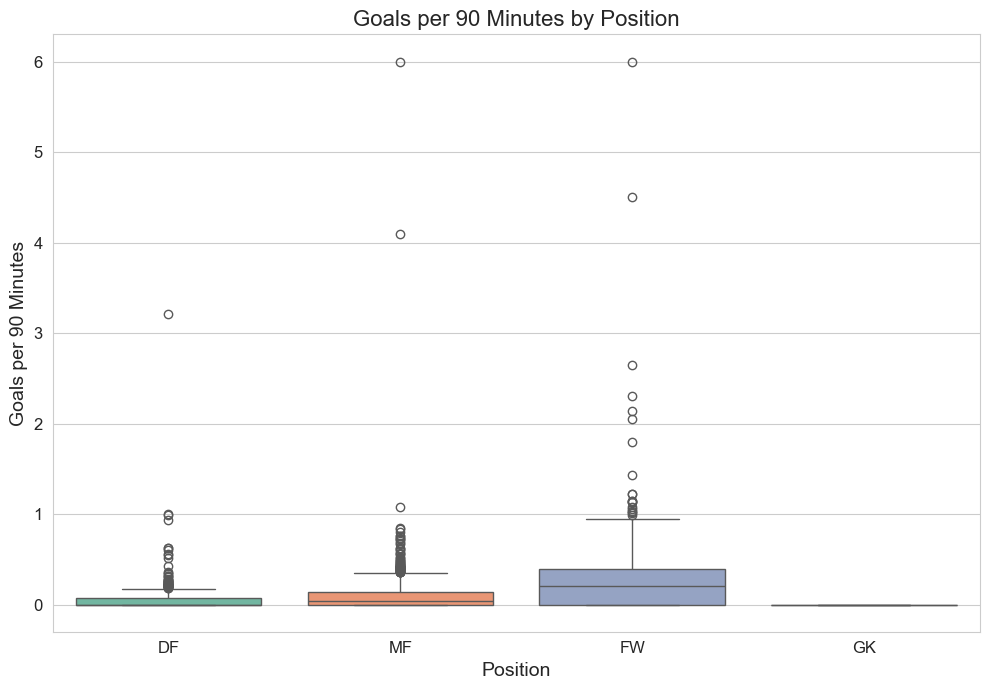

Expected goals per 90 minutes plot saved to artifacts/expected_goals_per_90_by_position.png


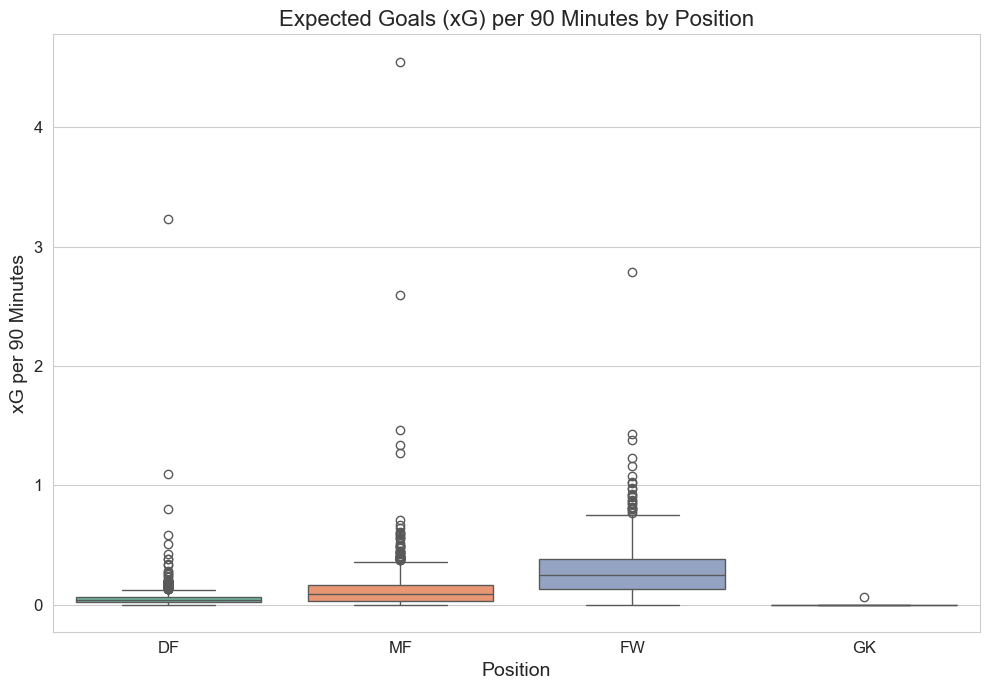

Assists per 90 minutes plot saved to artifacts/assists_per_90_by_position.png


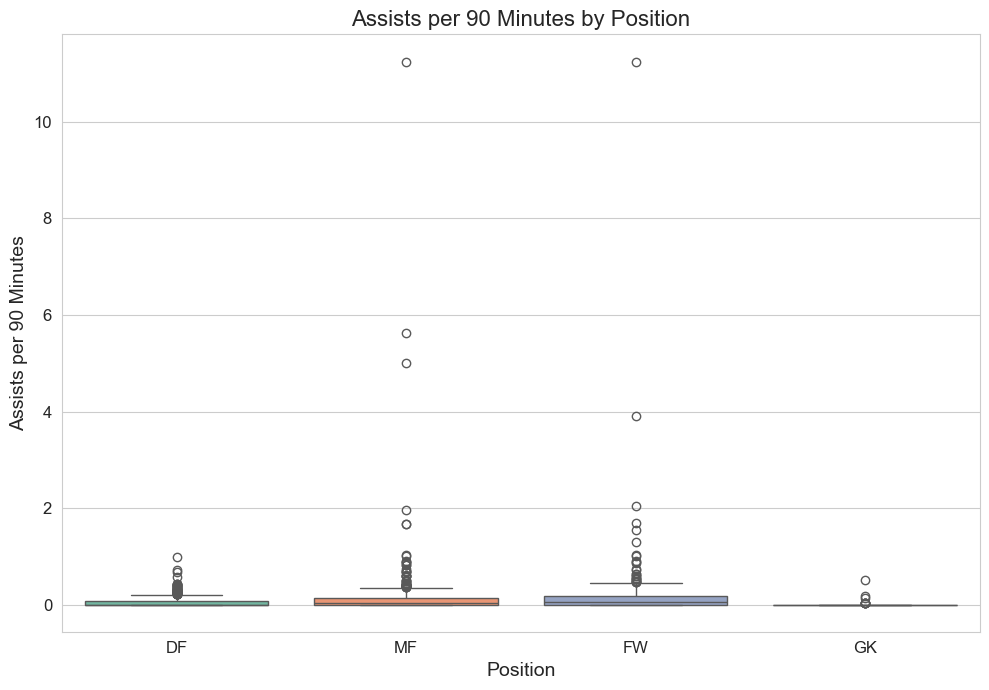

Expected assisted goals per 90 minutes plot saved to artifacts/expected_assisted_goals_per_90_by_position.png


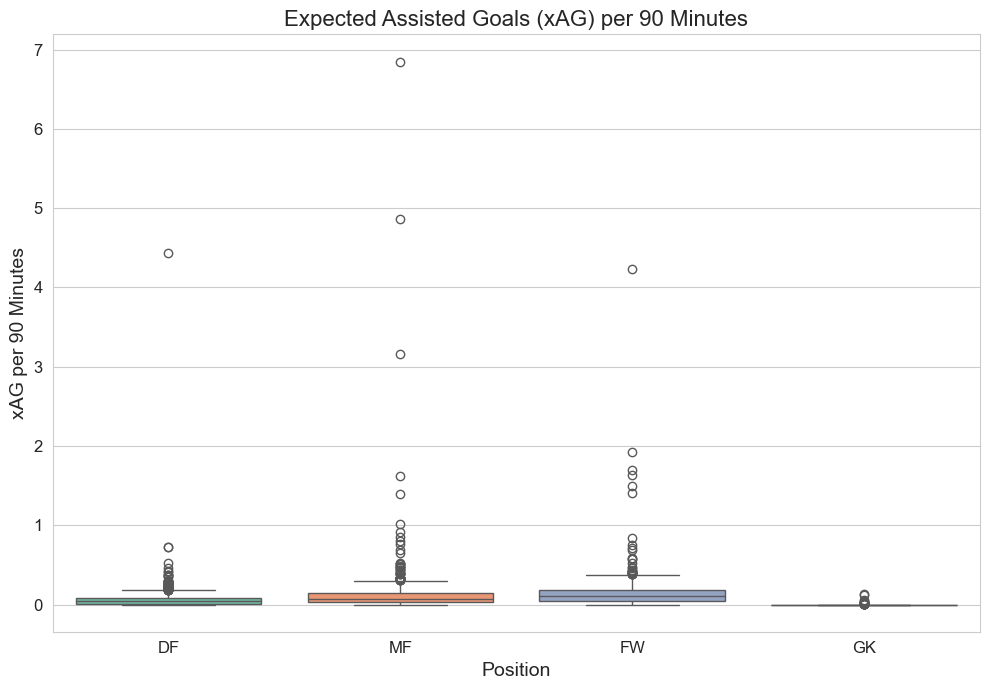

Yellow cards by position plot saved to artifacts/yellow_cards_by_position.png


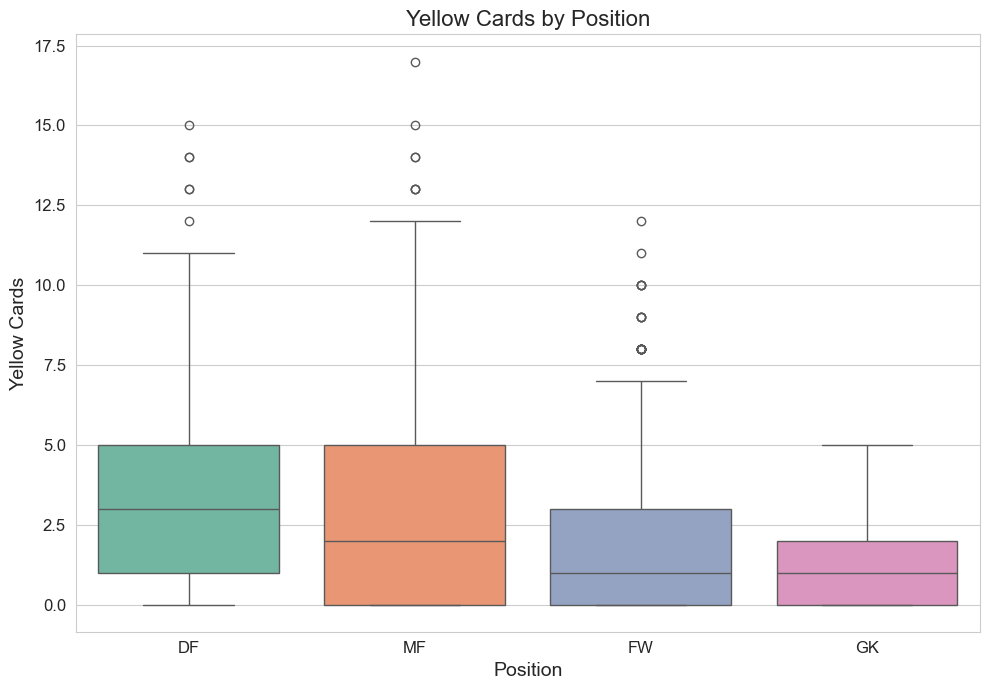

Progressive carries by position plot saved to artifacts/progressive_carries_by_position.png


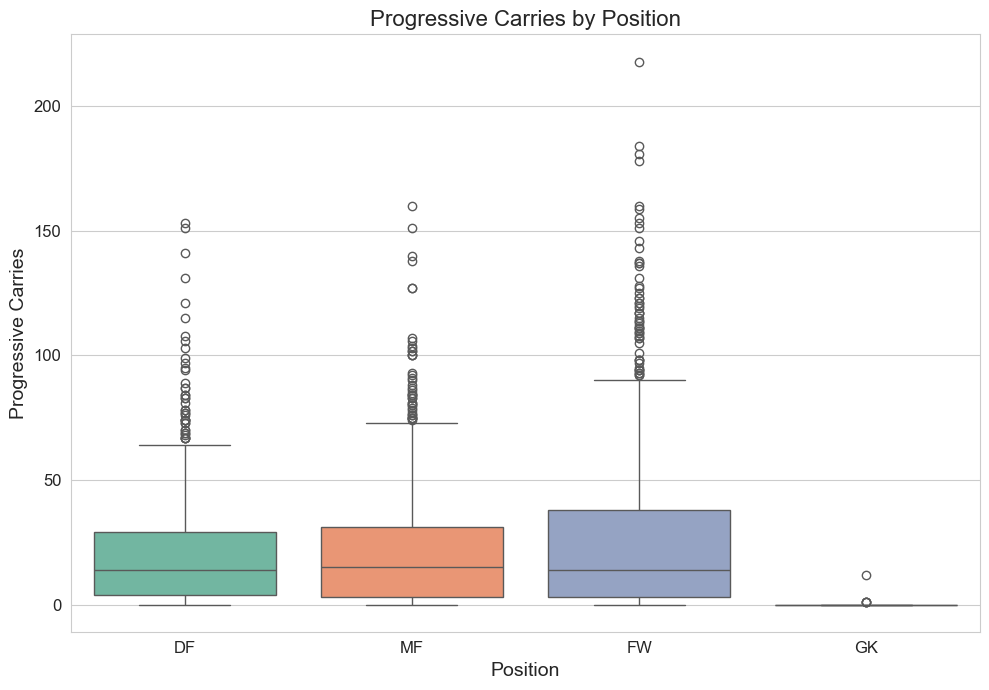

Original classes: ['DF' 'FW' 'GK' 'MF']
Encoded classes: [0 1 2 3]
Training set: 2281 samples
Test set: 571 samples
Numerical columns (30): ['Age', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'Gls_90', 'Ast_90', 'G+A_90', 'G-PK_90', 'G+A-PK_90', 'xG_90', 'xAG_90', 'xG+xAG_90', 'npxG_90', 'npxG+xAG_90']
Categorical columns (3): ['Nation', 'Squad', 'Comp']

Cross-validating LogisticRegression...
Mean Accuracy: 0.6900
Mean Macro-F1: 0.7177

Cross-validating RandomForestClassifier...
Mean Accuracy: 0.6874
Mean Macro-F1: 0.7316

Cross-validating XGBClassifier...
Mean Accuracy: 0.7295
Mean Macro-F1: 0.7714

Cross-validating KNeighborsClassifier...
Mean Accuracy: 0.6006
Mean Macro-F1: 0.6150

Best-performing model: XGBClassifier
Fitting XGBClassifier on full training data...
Classification report saved to artifacts/classification_report.txt
Accuracy saved to artifacts/accuracy.txt
Performanc

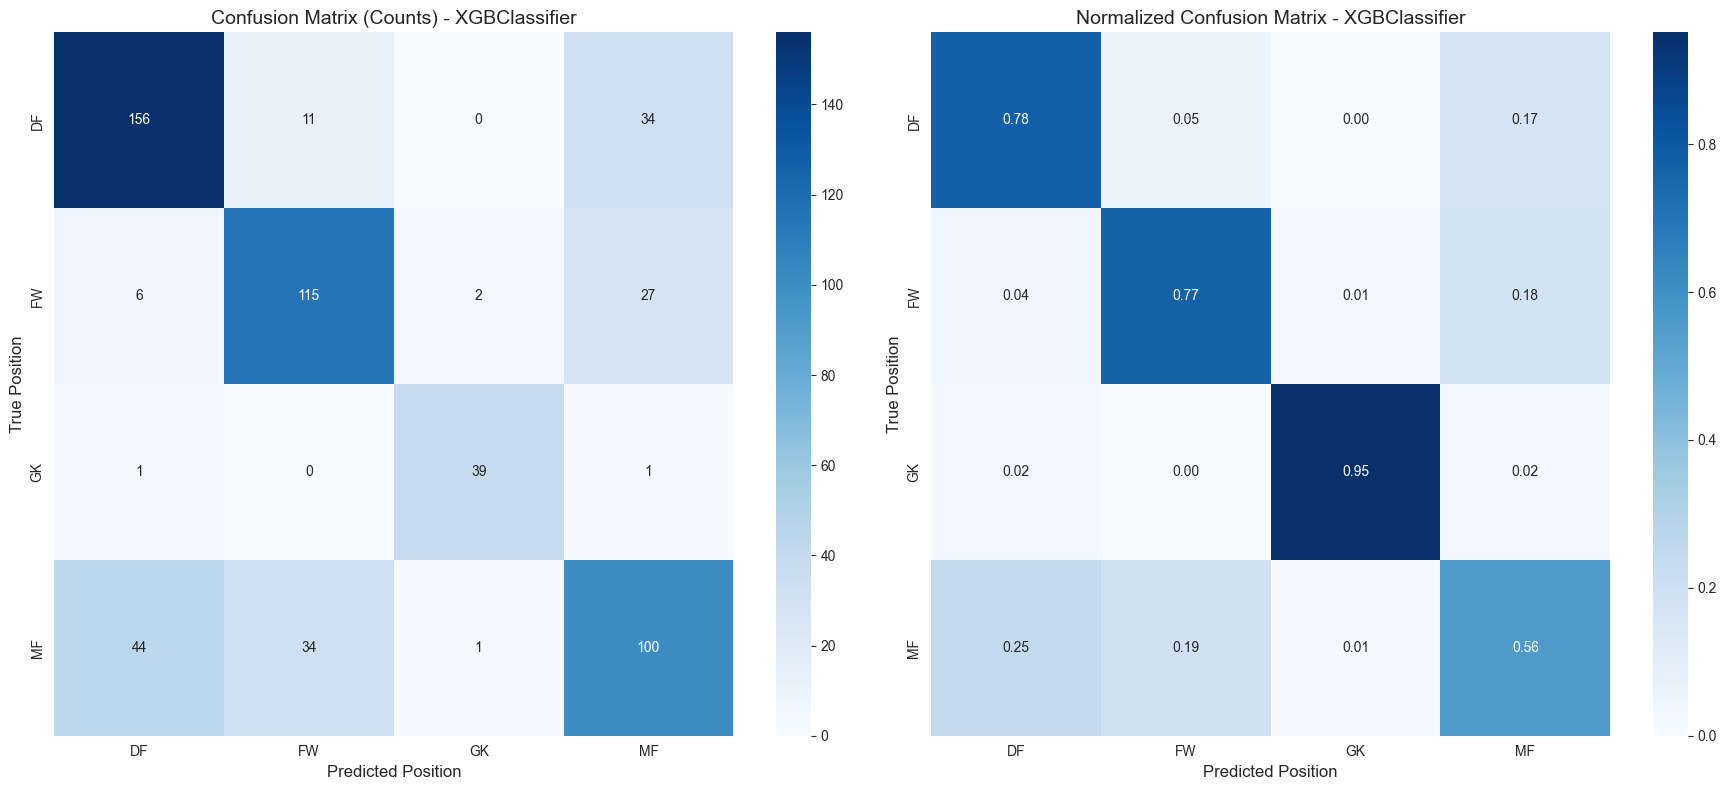

Classification report heatmap saved to artifacts/classification_report_heatmap.png


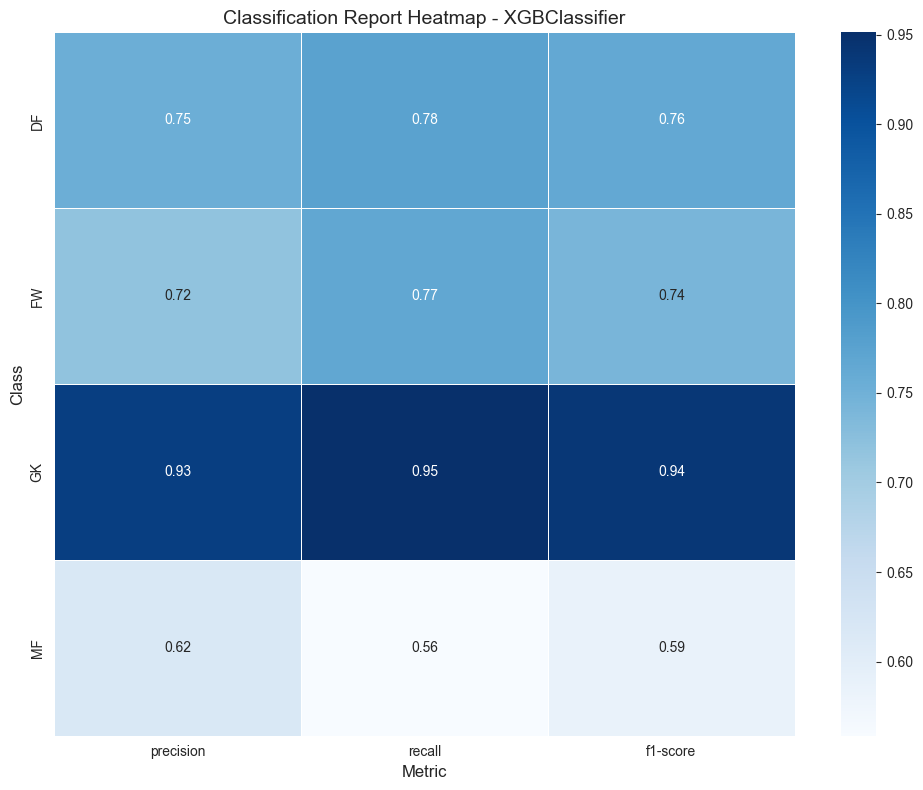

ROC curves saved to artifacts/roc_curves.png


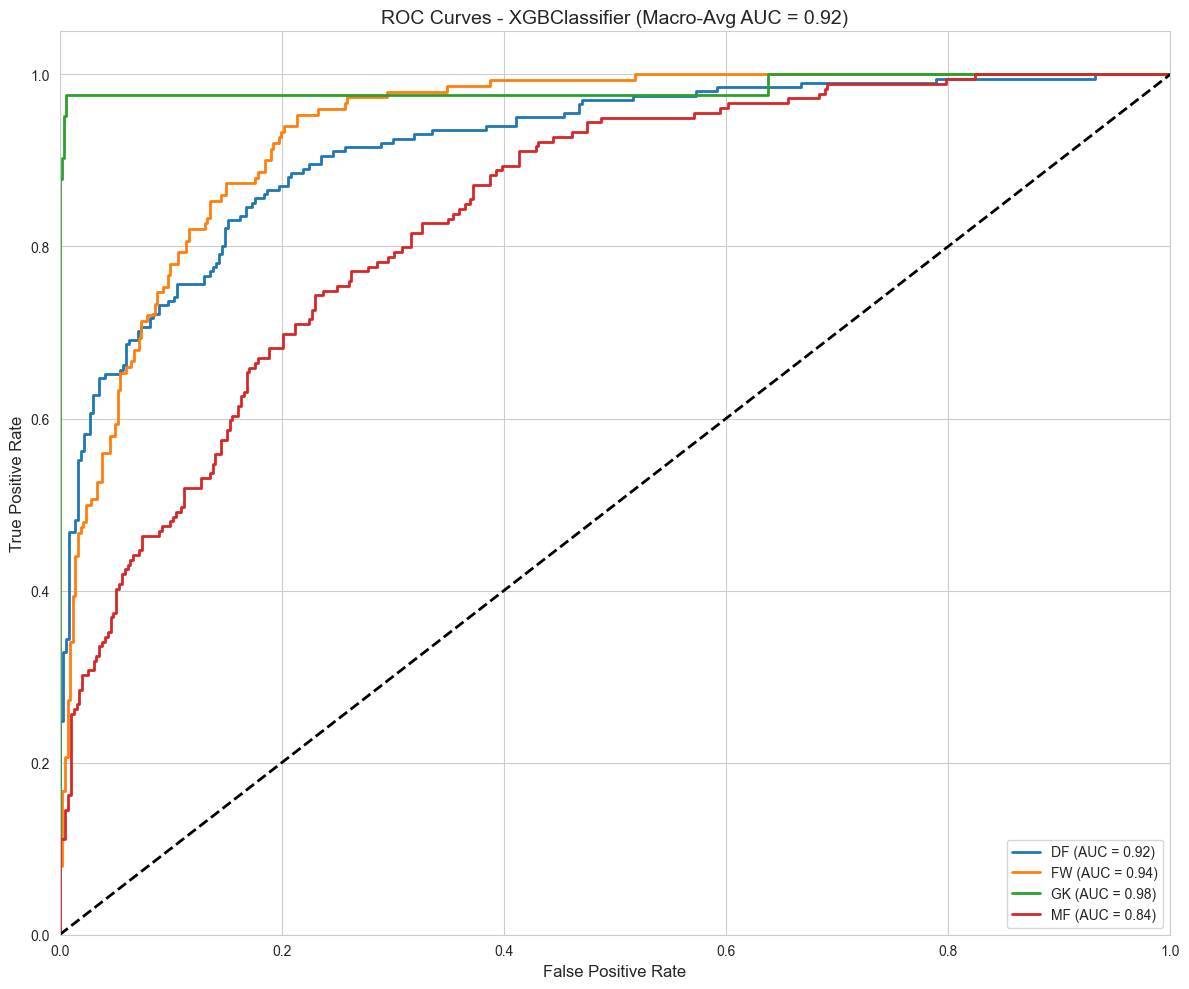

Computing feature importance...

Top 15 features by importance:
            Feature  Importance
              xG_90    0.034015
            npxG_90    0.030336
               PrgR    0.019864
          xG+xAG_90    0.018435
               PrgP    0.015784
        npxG+xAG_90    0.013179
                90s    0.012840
             Starts    0.010226
                Min    0.010188
   Squad_Heidenheim    0.010180
      Nation_cm CMR    0.010110
               PrgC    0.009919
   Squad_Leverkusen    0.009849
        Squad_Lazio    0.009571
Squad_Bayern Munich    0.009201
Feature importance plot saved to artifacts/feature_importance.png


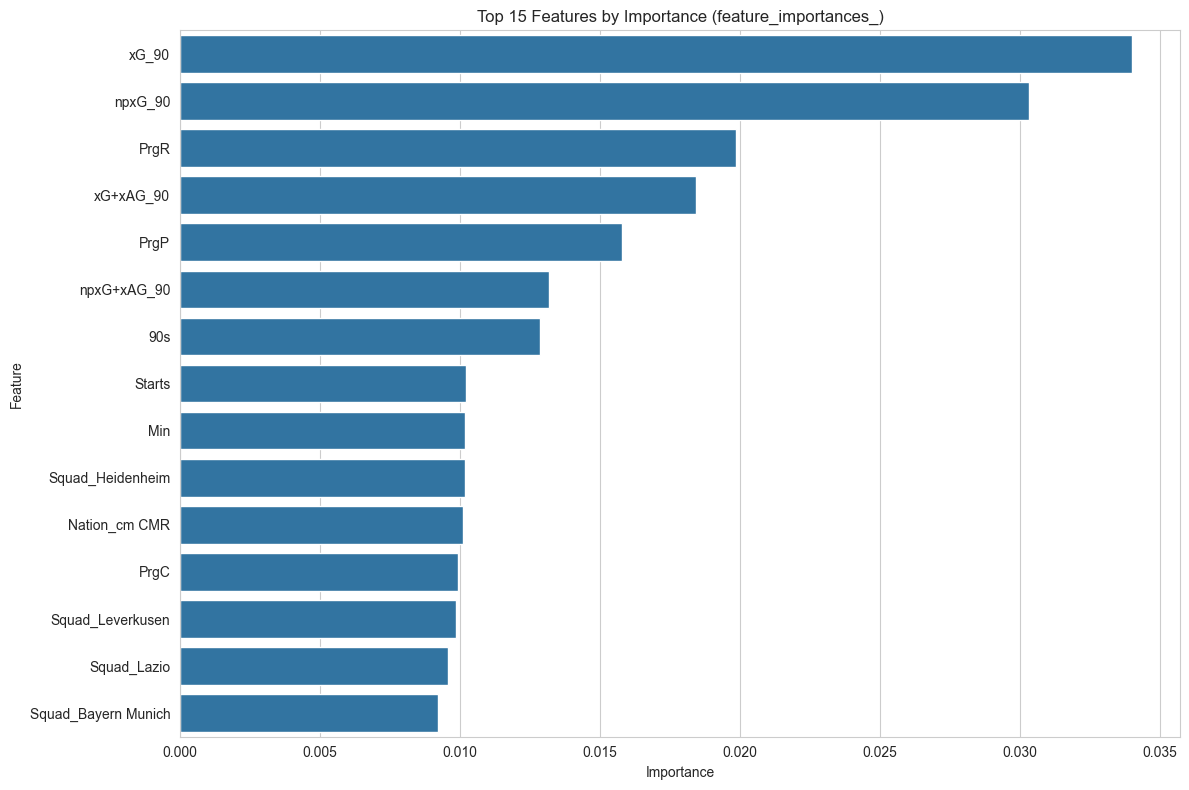

Saving model to artifacts/position_classifier.joblib...
Model saved successfully to artifacts/position_classifier.joblib


In [33]:
# Define function to run the full pipeline
def run_full_pipeline(data_path: str, artifacts_dir: str = 'artifacts') -> Dict[str, Any]:
    # Create artifacts directory
    pathlib.Path(artifacts_dir).mkdir(exist_ok=True)

    # 1. Load and explore data
    pipeline_df = load_data(data_path)
    explore_data(pipeline_df)

    # 2. Preprocess data
    pipeline_df_clean = preprocess_data(pipeline_df)

    # 2.1. Generate and save exploratory visualizations
    # Player demographics visualizations
    plot_age_distribution_by_position(pipeline_df_clean, f"{artifacts_dir}/age_distribution_by_position.png")
    plot_minutes_played_by_position(pipeline_df_clean, f"{artifacts_dir}/minutes_played_by_position.png")

    # Offensive metrics visualizations
    plot_goals_per_90_by_position(pipeline_df_clean, f"{artifacts_dir}/goals_per_90_by_position.png")
    plot_expected_goals_per_90_by_position(pipeline_df_clean, f"{artifacts_dir}/expected_goals_per_90_by_position.png")
    plot_assists_per_90_by_position(pipeline_df_clean, f"{artifacts_dir}/assists_per_90_by_position.png")
    plot_expected_assisted_goals_per_90_by_position(pipeline_df_clean, f"{artifacts_dir}/expected_assisted_goals_per_90_by_position.png")

    # Defensive and progression metrics visualizations
    plot_yellow_cards_by_position(pipeline_df_clean, f"{artifacts_dir}/yellow_cards_by_position.png")
    plot_progressive_carries_by_position(pipeline_df_clean, f"{artifacts_dir}/progressive_carries_by_position.png")

    # 3. Prepare features and targets
    pipeline_X, pipeline_y_encoded, pipeline_label_encoder = prepare_features_and_target(pipeline_df_clean)

    # 4. Split data
    pipeline_X_train, pipeline_X_test, pipeline_y_train, pipeline_y_test = create_train_test_split(pipeline_X, pipeline_y_encoded)

    # 5. Create preprocessor
    pipeline_preprocessor = create_preprocessor(pipeline_X)

    # 6. Cross-validate models
    pipeline_cv_results = cross_validate_models(pipeline_X_train, pipeline_y_train, pipeline_preprocessor)

    # 7. Get the best model
    pipeline_best_clf_name = pipeline_cv_results.iloc[0]['Classifier']
    print(f"\nBest-performing model: {pipeline_best_clf_name}")

    # 8. Train the best model
    pipeline_best_pipeline, pipeline_best_clf = train_best_model(pipeline_X_train, pipeline_y_train, pipeline_preprocessor, pipeline_best_clf_name)

    # 9. Evaluate model
    pipeline_evaluation_results = evaluate_model(pipeline_best_pipeline, pipeline_X_test, pipeline_y_test, pipeline_label_encoder, pipeline_best_clf_name)

    # 10. Save evaluation results
    save_evaluation_results(pipeline_evaluation_results, artifacts_dir)

    # 11. Plot confusion matrix
    plot_confusion_matrix(pipeline_evaluation_results, f"{artifacts_dir}/confusion_matrix.png")

    # 12. Plot classification report
    plot_classification_report(pipeline_evaluation_results, f"{artifacts_dir}/classification_report_heatmap.png")

    # 13. Plot ROC curves (if applicable)
    if pipeline_evaluation_results['roc_auc'] is not None:
        plot_roc_curves(pipeline_evaluation_results, f"{artifacts_dir}/roc_curves.png")

    # 14. Plot feature importance (if applicable)
    if pipeline_best_clf_name in ['RandomForestClassifier', 'XGBClassifier']:
        plot_feature_importance(pipeline_best_clf, pipeline_preprocessor, pipeline_X_train, f"{artifacts_dir}/feature_importance.png")

    # 15. Save model
    save_model(pipeline_best_pipeline, f"{artifacts_dir}/position_classifier.joblib")

    # Return pipeline results
    return {
        'pipeline_df': pipeline_df,
        'pipeline_df_clean': pipeline_df_clean,
        'pipeline_X': pipeline_X,
        'pipeline_y_encoded': pipeline_y_encoded,
        'pipeline_label_encoder': pipeline_label_encoder,
        'pipeline_X_train': pipeline_X_train,
        'pipeline_X_test': pipeline_X_test,
        'pipeline_y_train': pipeline_y_train,
        'pipeline_y_test': pipeline_y_test,
        'pipeline_preprocessor': pipeline_preprocessor,
        'pipeline_cv_results': pipeline_cv_results,
        'pipeline_best_clf_name': pipeline_best_clf_name,
        'pipeline_best_pipeline': pipeline_best_pipeline,
        'pipeline_best_clf': pipeline_best_clf,
        'pipeline_evaluation_results': pipeline_evaluation_results
    }

# Run the full pipeline in one go
# The following line runs the entire pipeline with a single function call
results = run_full_pipeline('data/top5-players.csv')
